# ADA2017 project, milestone 2
# Data processing pipeline

In [1]:
# To use Spark 1.6.3 in Jupyter Notebook we have to use Python 3.4
!python --version

Python 3.6.1 :: Anaconda custom (64-bit)


In [2]:
# USER to determine spark and dataset directories
import getpass
USER = getpass.getuser()
if USER == 'Tarmo':
    SPARK_DIR = 'C:/Users/Tarmo/Documents/Lausanne/CS-401_applied_data_analysis/spark/spark-1.6.3-bin-hadoop2.6'
    DATASET_DIR = 'C:/Users/Tarmo/Documents/Lausanne/data/Books_5.json'
    METADATA_DIR = 'C:/Users/Tarmo/Documents/Lausanne/data/meta_Books.json'
elif USER == 'adam':
    SPARK_DIR = '/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'
    DATASET_DIR = '/media/adam/B236CB1D36CAE209/Studia/ADA/reviews_Books_5.json'
    METADATA_DIR = '/media/adam/B236CB1D36CAE209/Studia/ADA/meta_Books.json'
else:
    SPARK_DIR = '/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'

In [3]:
SPARK_DIR

'/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'

### Import libraries
#### Spark libraries

In [4]:
import findspark
findspark.init(SPARK_DIR)

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import to_date, unix_timestamp, from_unixtime  #to_timestamp, pyspark 2.2 functiona 

#### The others

In [2]:
import pandas as pd
from scipy import stats
import numpy as np
import json
import re
import json 
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import resample
from scipy import stats
from collections import Counter
import operator
import matplotlib.cm as cm
%matplotlib inline

# Collection and aggregation of data
Loading and processing the data to see what it contains. To make further processing faster, we create intermediate well-structured csv files to avoid having to process the JSON data files every time we want to look at the data. We take a look at several different metrics and their aggregates in the data (review length, review number; by day, by month, by year, by book, etc.)

### Initialization of Spark and SQL context

In [6]:
sc = SparkContext()
sqlContext = SQLContext(sc)

sc.version

'1.6.3'

### Loading of dataset and metadata

In [8]:
# Load the dataset and create RDDs
text_file = sc.textFile(DATASET_DIR)
# Convert previously read text file to json DataFrame
df = sqlContext.read.json(text_file)

# Load metadata for dataset and convert it to DataFrame
metadata = sc.textFile(METADATA_DIR)
metadata_df = sqlContext.read.json(metadata)

# Register DataFrames as tables to use those names in SQL-type queries
sqlContext.registerDataFrameAsTable(metadata_df, "metadata")
sqlContext.registerDataFrameAsTable(df, "dataset")

In [109]:
# Number of RDDs
text_file.getNumPartitions()

282

In [110]:
# Number of records in the dataset
text_file.count()

8898041

In [9]:
# Schema of the dataset
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



### Initial data processing

In [10]:
# Bunch of castings, reviewTime: string->date, unixReviewTime: int->timestamp
# We do this to be able to better filter and manipulate the data
df = df.withColumn('unixReviewTime', from_unixtime(df['unixReviewTime']))
df = df.withColumn('reviewTime', to_date(df['unixReviewTime']))
df = df.withColumn('unixReviewTime', df['unixReviewTime'].cast('timestamp'))
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: date (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: timestamp (nullable = true)



In [113]:
# Look at couple of records, just to be sure that we obtained what we wanted
df.select("reviewTime", 'reviewText', 'unixReviewTime').take(2)

[Row(reviewTime=datetime.date(2012, 12, 16), reviewText='Spiritually and mentally inspiring! A book that allows you to question your morals and will help you discover who you really are!', unixReviewTime=datetime.datetime(2012, 12, 16, 1, 0)),
 Row(reviewTime=datetime.date(2003, 12, 11), reviewText="This is one my must have books. It is a masterpiece of spirituality. I'll be the first to admit, its literary quality isn't much. It is rather simplistically written, but the message behind it is so powerful that you have to read it. It will take you to enlightenment.", unixReviewTime=datetime.datetime(2003, 12, 11, 1, 0))]

### Average length of reviews per day

In [ ]:
# Computing an average length of review per day
aTuple = (0, 0)
avg = df.select("reviewTime", 'reviewText').rdd.map(lambda row: (row.reviewTime, len(row.reviewText)))
avg = avg.aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg = avg.mapValues(lambda v: v[0]/v[1])
avg = avg.collect()

In [ ]:
# Processing acquired data using Pandas
avg_len = pd.DataFrame(avg, columns=['Date', 'Avg_length'])
avg_len['Date'] = pd.to_datetime(avg_len['Date'])
avg_len.set_index('Date', inplace=True)
avg_len.sort_index(inplace=True)
avg_len.head()

In [ ]:
# Save to file not to compute this one more time
avg_len.to_csv("avg_length_review_by_day.csv")

In [6]:
avg_len = pd.read_csv("avg_length_review_by_day.csv", index_col='Date', parse_dates=['Date'])
avg_len.head()

,Avg_length
Date,
1996-05-20,1752.0
1996-06-25,1123.0
1996-08-17,826.0
1996-09-18,897.0
1996-11-15,1757.0


### Average length of reviews per month

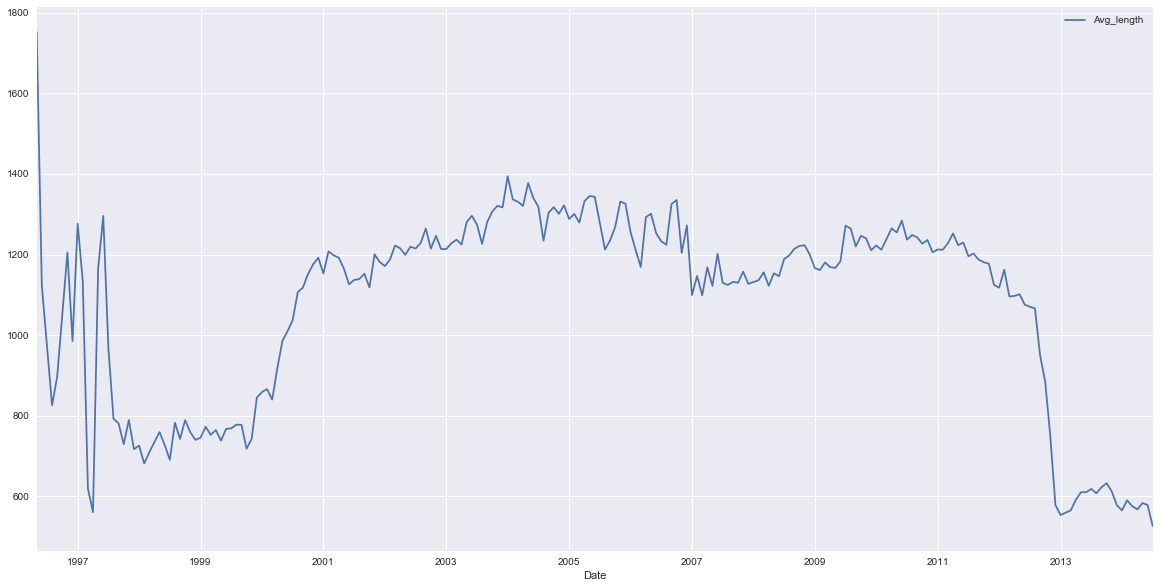

In [115]:
monthly_data = avg_len.groupby(avg_len.index.to_period('M')).mean()
monthly_data.plot(figsize=(20,10))

We notice that the average review length per month appears to have three somewhat stable levels in time: before 2000, between 2000 and 2013 and after 2013. In the middle period the review length is consistently high, and crashes around 2012-2013. In the beginning of the dataset time period, the number of reviews is small so there is high variation in monthly average.

### Average length of reviews between 2012 and 2013

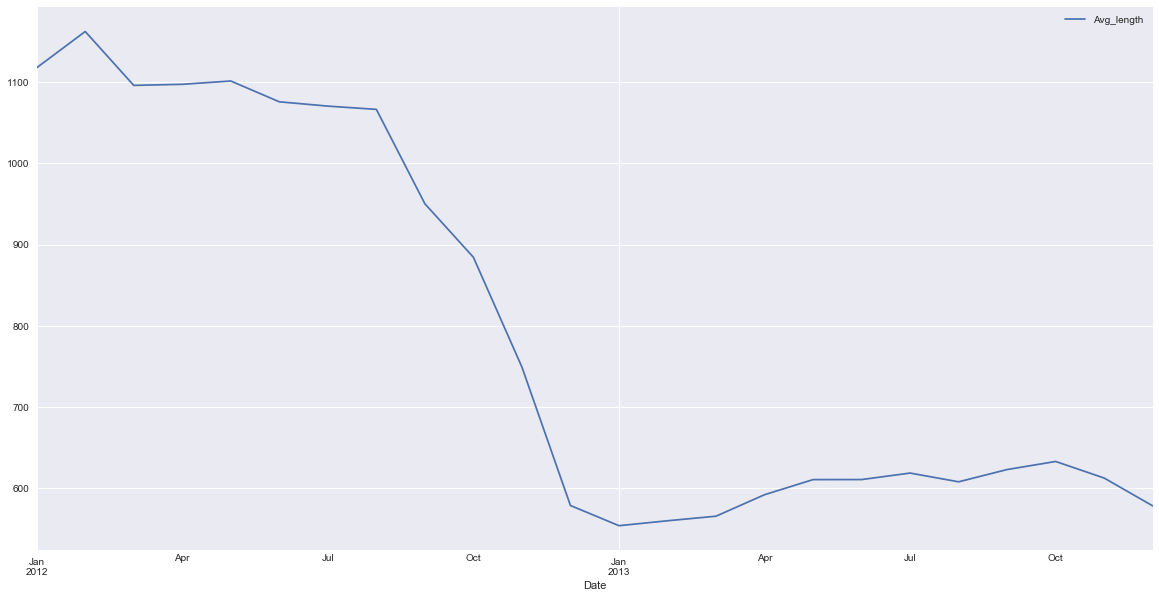

In [116]:
monthly_data['2012':'2013'].plot(figsize=(20,10))

The extreme drop is located between August 2012 and January 2013.

In [ ]:
# Save processed data
monthly_data.to_csv("avg_length_review_by_month.csv")

In [ ]:
# (Successful) attempt to filter by timestamp 
tmp = df.rdd.filter(lambda row: row.unixReviewTime > pd.to_datetime('2012-05')
                     and row.unixReviewTime < pd.to_datetime('2013'))
tmp.take(5)

### Number of reviews per each day

In [ ]:
# Number of reviews per each day
number_of_reviews = df.rdd.map(lambda row: (row.reviewTime, 1)).reduceByKey(lambda a, b: a+b).collect()

In [ ]:
# Processing the data
rev_num = pd.DataFrame(number_of_reviews, columns=['Date', 'Number of reviews'])
rev_num['Date'] = pd.to_datetime(rev_num['Date'])
rev_num.set_index('Date', inplace=True)
rev_num.sort_index(inplace=True)
rev_num.head()

In [ ]:
# Save the data not to compute over and over
rev_num.to_csv("number_of_reviews_per_day.csv")

In [9]:
# Read file with the data
rev_num = pd.read_csv("number_of_reviews_per_day.csv", index_col='Date', parse_dates=['Date'])
rev_num.tail()

,Number of reviews
Date,
2014-07-19,2797
2014-07-20,3332
2014-07-21,3456
2014-07-22,2697
2014-07-23,619


### Number of reviews per month

In [ ]:
monthly_data_reviews = rev_num.groupby(rev_num.index.to_period('M')).sum()
# Save the processed data
monthly_data_reviews.to_csv("number_of_reviews_per_month.csv")

In [118]:
# Read file with the data
monthly_data_reviews = pd.read_csv("number_of_reviews_per_month.csv", index_col='Date', parse_dates=['Date'])

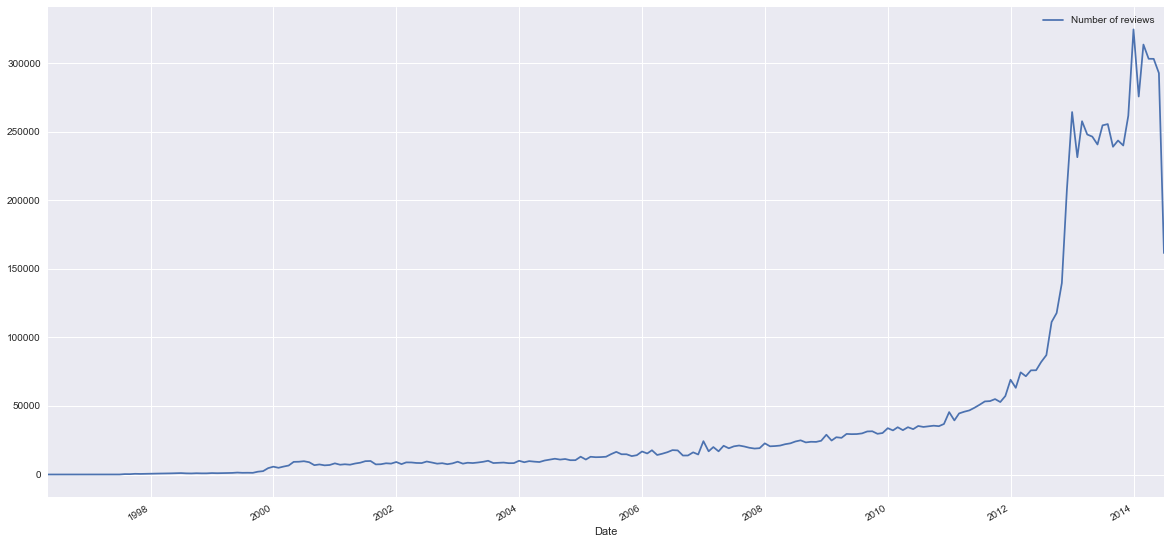

In [119]:
monthly_data_reviews.plot(figsize=(20,10))

We see that in the beginning of the data period, there are hardly any reviews being written. The number of reviews increases consistently until there is a huge jump after 2012. The extreme increase coincides with the drop in the average review length, and may reflect a sudden change in reviewer numbers and/or behavior. The apparent increase might also be due to changes in Amazon review policies: after a significant change, Amazon might retroactively remove old reviews not conforming to the new policy.

### Number of reviews per book

In [ ]:
number_of_reviews_per_book = df.rdd.map(lambda row: (row.asin, 1)).reduceByKey(lambda a, b: a+b).collect()
len(number_of_reviews_per_book)

In [ ]:
# Processing the data using Pandas and saving it to csv file
df_number_of_reviews_per_book = pd.DataFrame(number_of_reviews_per_book, columns=['Book_id', 'Number of reviews'])
df_number_of_reviews_per_book.sort_values('Number of reviews', ascending=False, inplace = True)
df_number_of_reviews_per_book.to_csv("number_of_reviews_per_book.csv", index=False)
df_number_of_reviews_per_book.head(10)

In [120]:
# Read file with the data
df_number_of_reviews_per_book = pd.read_csv("number_of_reviews_per_book.csv", index_col='Book_id')

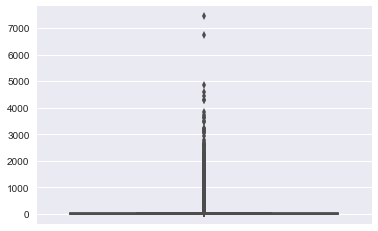

In [129]:
# Boxplot of numbers of reviews
sns.boxplot(np.array(df_number_of_reviews_per_book['Number of reviews'].values), orient='v')

The boxplot is not very box-like, since most books have only a small number of reviews.

We look at the numbers without the outliers:

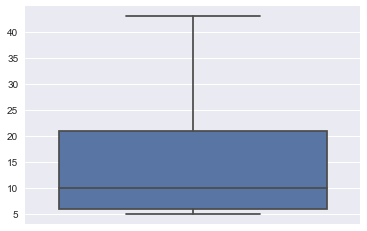

In [130]:
sns.boxplot(np.array(df_number_of_reviews_per_book['Number of reviews'].values), orient='v', showfliers=False)

In [131]:
# Basic statistics for this variable
stats.describe(df_number_of_reviews_per_book['Number of reviews'].values)

DescribeResult(nobs=367982, minmax=(5, 7440), mean=24.180641987923323, variance=4396.0938613274502, skewness=25.747403776095645, kurtosis=1461.9790549248125)

## Top 30 books based on the number of reviews
Our time-independent popularity metric is the number of reviews, so we take a closer look at the top 30 books according to it.

In [ ]:
top_books = df.rdd.map(lambda row: (row.asin, 1)).reduceByKey(lambda a, b: a+b).sortBy(lambda wc: -wc[1]).take(30)

top_books_df = sqlContext.createDataFrame(top_books, ['asin', 'rew_num'])
sqlContext.registerDataFrameAsTable(top_books_df, "top_books")
top_books_df.take(5)

In [ ]:
# Join the dataset table with the metadata table to see titles of the most popular books
sqlContext.sql("select t.asin, m.title from metadata m join top_books t on m.asin=t.asin").collect()

In [ ]:
sqlContext.sql("select t.asin, m.title from metadata m join top_books t limit 10").collect()

### Two methods of filtering by ids of books

In [ ]:
most_reviewed_books_id_top = df_number_of_reviews_per_book[:30]
most_reviewed_top = df.rdd.filter(lambda row: row.asin in list(most_reviewed_books_id_top.Book_id))
            .map(lambda row: (row.asin, row.reviewTime)).collect()

In [ ]:
most_reviewed_top_2 = sqlContext.sql("select asin, reviewTime from dataset where asin in " + 
               str(tuple(most_reviewed_books_id_top.Book_id)))

### Processing the data for top30 books

In [ ]:
# Processing the data using Pandas
most_reviewed_books_top30_df = pd.DataFrame(most_reviewed_top, columns=['asin', 'reviewTime'])
# Convert to datetime type
most_reviewed_books_top30_df['reviewTime'] = pd.to_datetime(most_reviewed_books_top30_df['reviewTime'])
# Assign number of review to compute the sum
most_reviewed_books_top30_df['Number_of_reviews'] = 1
# Create monthly period for aggregation purpose
most_reviewed_books_top30_df['Year-month'] = most_reviewed_books_top30_df['reviewTime'].dt.to_period('M')
most_reviewed_books_top30_df.head()

In [ ]:
# Save data describing number of reviews per day for each book in top30
most_reviewed_books_top30_df.groupby(['asin', 'reviewTime']).sum()
                            .to_csv("number_of_reviews_per_day_top30_books.csv")

In [ ]:
# Aggregating the data by month
m_rev_books_by_month = most_reviewed_books_top30_df.groupby(['asin', 'Year-month'], as_index=True).sum()
m_rev_books_by_month.to_csv("number_of_reviews_per_month_top30_books.csv")

In [133]:
m_rev_books_by_month = pd.read_csv("number_of_reviews_per_month_top30_books.csv").set_index(['asin', 'Year-month'])

### Multi-line plot for top30 books - timeseries of reviews per month

In [ ]:
m_rev_books_by_month.unstack(level=0).to_csv("number_of_reviews_per_month_top30_books_UNSTACKED.csv")

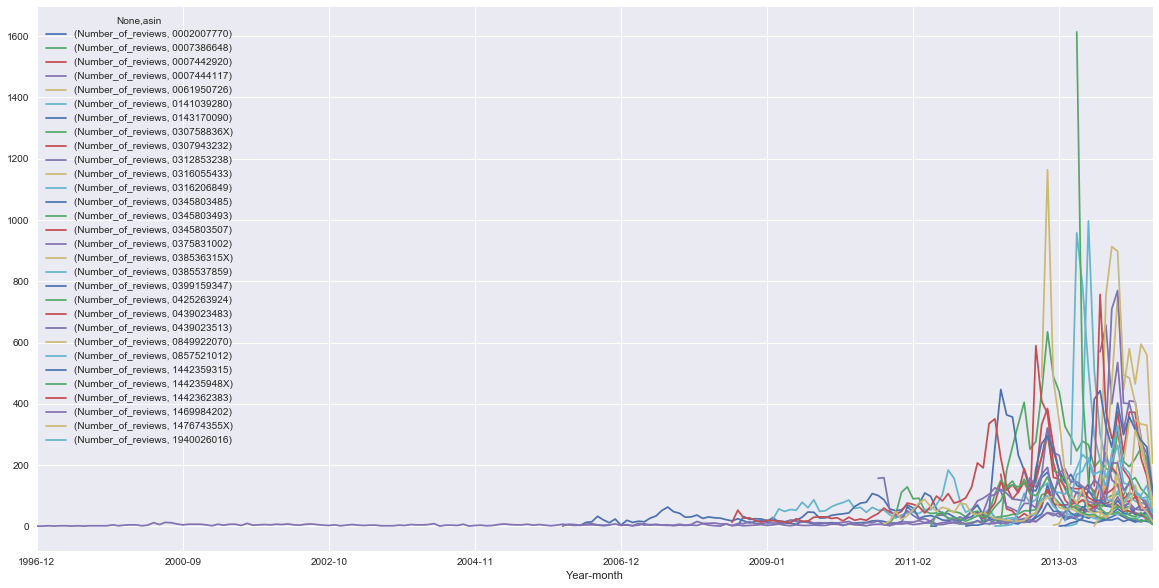

In [134]:
m_rev_books_by_month.unstack(level=0).plot(figsize = (20,10))

We see that for the top 30 books, most reviews are made after January 2013.

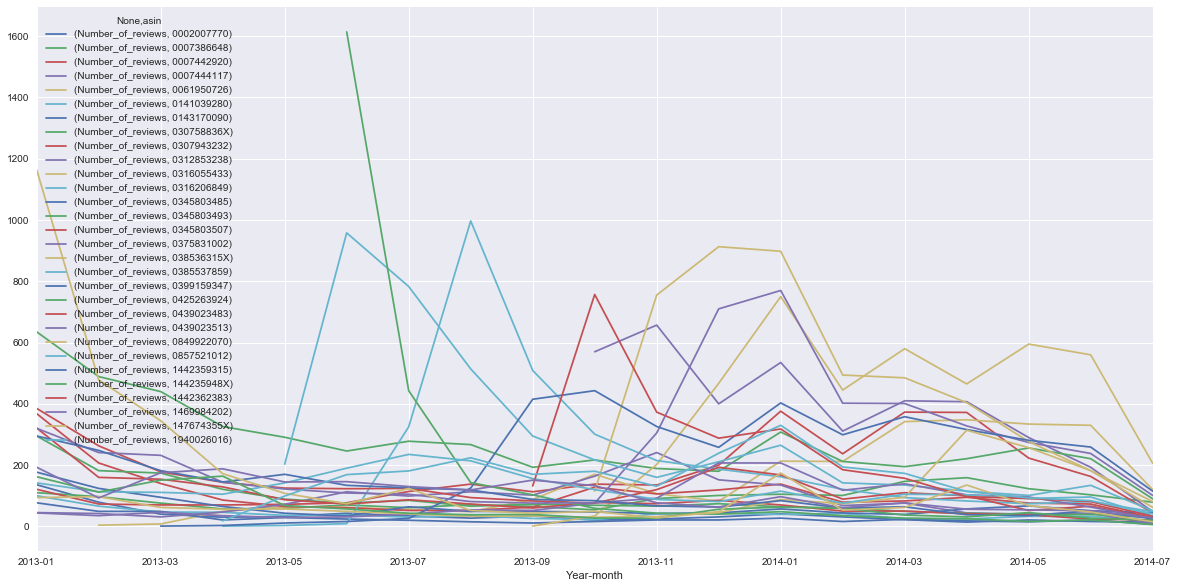

In [135]:
m_rev_books_by_month.unstack(level=0)['2013':].plot(figsize = (20,10))

A top 30 book accrues a lot of reviews right after publication (or rather, appearance of first review). It is highly book-dependent whether this rate of reviewing drops quickly or slowly.

### Average length and number of reviews per book

In [ ]:
aTuple = (0, 0)
avg_len_review = df.select('asin', 'reviewText').rdd.map(lambda row: (row.asin, len(row.reviewText)))
avg_len_review = avg_len_review.aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg_len_review = avg_len_review.mapValues(lambda v: (v[0]/v[1], v[1]))
avg_len_review = avg_len_review.collect()

In [ ]:
# Transformation of the data to be able to load it as a DataFrame 
avg_len_review = [(k, v1, v2) for k, (v1, v2) in avg_len_review]

In [ ]:
# Processing and saving to file
avg_len_review_per_book_df = pd.DataFrame(avg_len_review, columns=['Book_id', 'Avg_len', 'number_of_reviews'])
avg_len_review_per_book_df.sort_values(['Avg_len', 'number_of_reviews'], ascending=False, inplace=True)
avg_len_review_per_book_df.to_csv("avg_length_and_number_of_reviews_per_book.csv", index=False)
avg_len_review_per_book_df.head(10)

In [24]:
avg_len_review_per_book_df = pd.read_csv("avg_length_and_number_of_reviews_per_book.csv",index_col="Book_id")
avg_len_review_per_book_df.head()

,Avg_len,number_of_reviews
Book_id,,
0195396170,13459.5,6
0700619542,9934.8,5
0061312118,9511.1,10
0875522645,9377.8,5
1405159286,8716.0,9


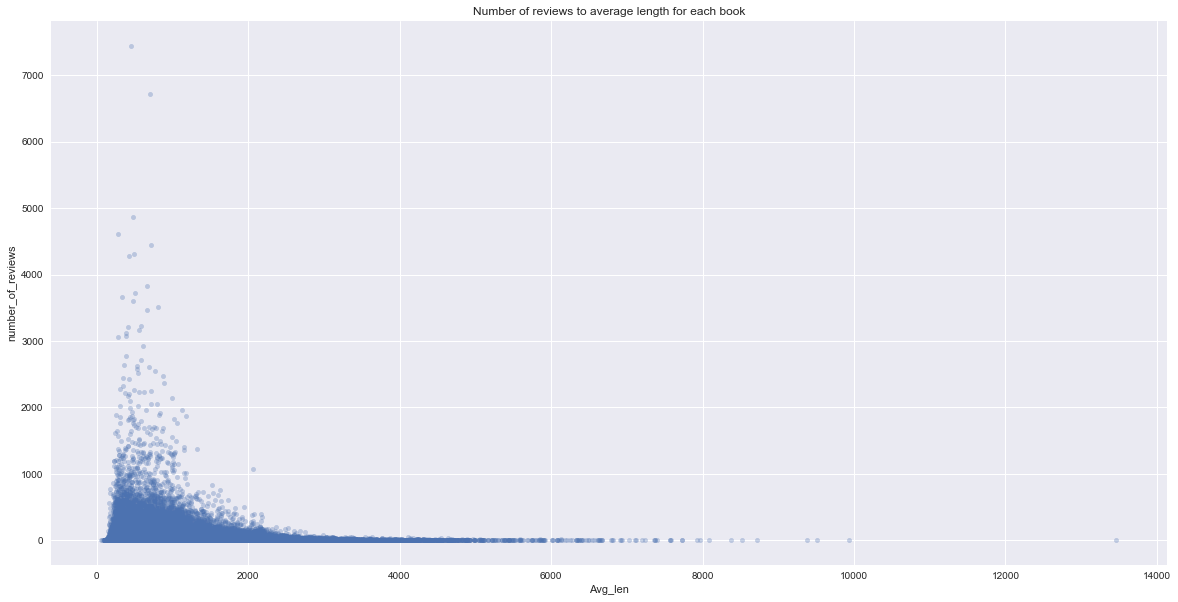

In [8]:
avg_len_review_per_book_df.plot(x = 'Avg_len', y = 'number_of_reviews', kind = 'scatter', figsize = (20,10), 
                       alpha = 0.3, title = 'Number of reviews to average length for each book')

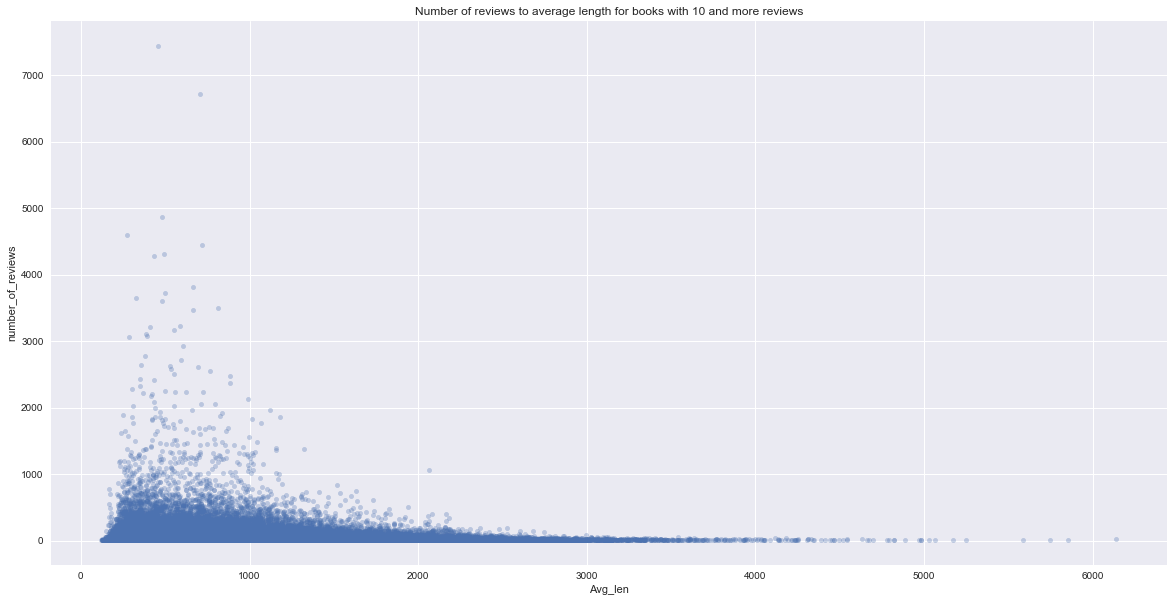

In [10]:
avg_len_review_per_book_df[avg_len_review_per_book_df['number_of_reviews'] > 10].plot(x = 'Avg_len', y = 'number_of_reviews', kind = 'scatter', figsize = (20,10), 
                       alpha = 0.3, title = 'Number of reviews to average length for books with 10 and more reviews')

## Ratings
### Collecting the data about ratings
Each row contains: book serial number, date of the review, rating (overall). We construct an intermediate file where each book (asin) is associated with five column features, which give the number of ratings from 1 to 5, respectively.

Rating is in stars (integers), from 1 to 5.

In [ ]:
ratings = df.select("asin", "reviewTime", "overall").rdd.map(lambda row: (row.asin, row.reviewTime, int(row.overall))).collect()

In [ ]:
ratings_df = pd.DataFrame(ratings, columns=['asin', 'Date', 'rating'])
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])
ratings_df.shape

In [3]:
# Save the data
ratings_df.to_csv("ratings.csv", index=False)

NameError: name 'ratings_df' is not defined

In [16]:
ratings_df = pd.read_csv("ratings.csv", parse_dates=['Date'])
ratings_df['Year-month'] = ratings_df['Date'].dt.to_period('M')
ratings_grouped_df = ratings_df[['Year-month', 'rating', 'asin']].groupby(['Year-month', 'rating']).count()
ratings_grouped_unstack_date_df = ratings_grouped_df.unstack(level=1)
ratings_grouped_unstack_date_df.head()

asin                   
rating        1    2   3    4    5
Year-month                        
1996-05     NaN  NaN NaN  1.0  NaN
1996-06     1.0  NaN NaN  NaN  NaN
1996-08     NaN  NaN NaN  NaN  1.0
1996-09     NaN  NaN NaN  NaN  1.0
1996-11     NaN  2.0 NaN  2.0  2.0

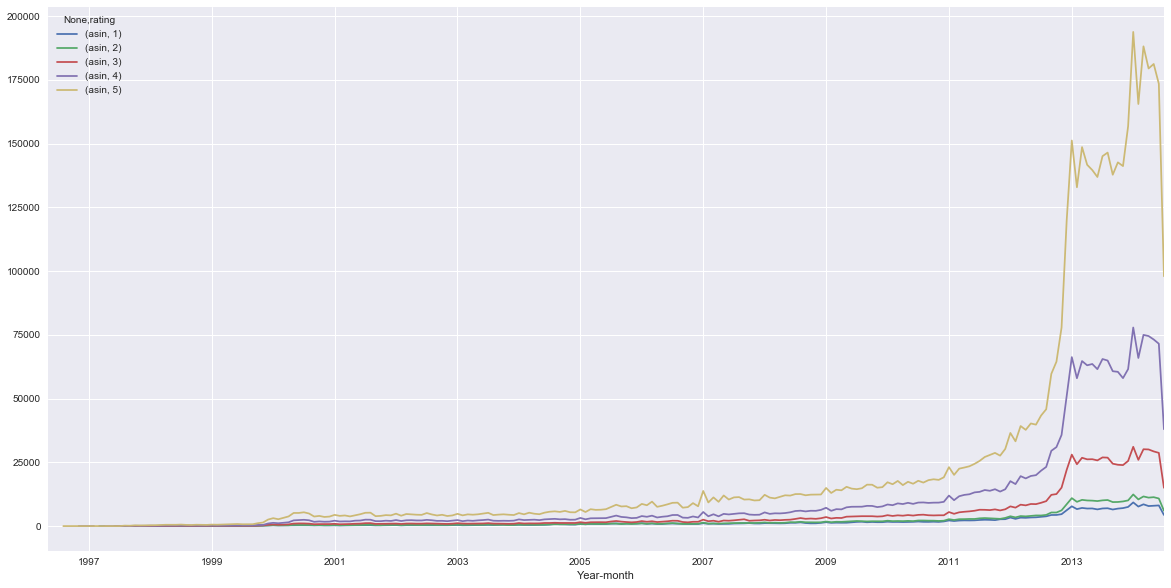

In [5]:
ratings_grouped_unstack_date_df.plot(figsize = (20,10))

In [17]:
# Aggregate data by number of each 1, 2, 3, 4, 5 ratings

ratings_grouped_asin_df = ratings_df[['Year-month', 'rating', 'asin']].groupby(['asin', 'rating']).count()
ratings_grouped_asin_unstack_df = ratings_grouped_asin_df.unstack(level=1, fill_value=0)
ratings_grouped_asin_unstack_df.columns = ratings_grouped_asin_unstack_df.columns.droplevel()
ratings_grouped_asin_unstack_df.head()

rating,1,2,3,4,5
asin,,,,,
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5


In [18]:
ratings_grouped_asin_unstack_df.to_csv("ratings_grouped_unstack.csv")

In [19]:
ratings_grouped_unstack_df = pd.read_csv('ratings_grouped_unstack.csv', index_col='asin')
ratings_grouped_unstack_df.head()

,1,2,3,4,5
asin,,,,,
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5


Column 1 contains the number of 1-star ratings, etc.

In [20]:
ratings_grouped_unstack_df.rename(columns={1:"1", 2:"2", 3:"3", 4:"4", 5:"5"}, inplace=True)

In [21]:
# Calculating weighted mean and standard deviation
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis = 1)
    variance = np.average(((values.T-average).T)**2, weights=weights, axis = 1)
    return (average, np.sqrt(variance))

In [22]:
ratings_grouped_unstack_df['Weighted_mean'], ratings_grouped_unstack_df['Std_dev'] = weighted_avg_and_std(
    values = np.broadcast_to([1,2,3,4,5], (ratings_grouped_unstack_df.shape[0],5)),
    weights = np.array(ratings_grouped_unstack_df[['1', '2', '3', '4', '5']].values))

ratings_grouped_unstack_df['Number_of_reviews'] = np.sum(np.array(ratings_grouped_unstack_df[['1', '2', '3', '4', '5']].values), axis = 1)

ratings_grouped_unstack_df.head()

,1,2,3,4,5,Weighted_mean,Std_dev,Number_of_reviews
asin,,,,,,,,
000100039X,6,4,8,15,173,4.674757,0.873584,206
0001055178,0,4,2,10,2,3.555556,0.955814,18
0001473123,1,0,0,2,13,4.625000,0.992157,16
0001473727,0,0,0,0,7,5.000000,0.000000,7
0001473905,0,0,1,0,5,4.666667,0.745356,6


In [25]:
ratings_grouped_unstack_df = pd.merge(ratings_grouped_unstack_df, avg_len_review_per_book_df, right_index=True, left_index=True)
ratings_grouped_unstack_df.drop('number_of_reviews', inplace = True, axis = 1)
ratings_grouped_unstack_df.head()

,1,2,3,4,5,Weighted_mean,Std_dev,Number_of_reviews,Avg_len
000100039X,6,4,8,15,173,4.674757,0.873584,206,638.033981
0001055178,0,4,2,10,2,3.555556,0.955814,18,1308.611111
0001473123,1,0,0,2,13,4.625000,0.992157,16,287.937500
0001473727,0,0,0,0,7,5.000000,0.000000,7,187.571429
0001473905,0,0,1,0,5,4.666667,0.745356,6,481.833333


In [35]:
ratings_grouped_unstack_df.describe()

,1,2,3,4,5,Weighted_mean,Std_dev,Number_of_reviews,Avg_len
count,367982.000000,367982.000000,367982.000000,367982.000000,367982.000000,367982.000000,367982.000000,367982.000000,367982.000000
mean,0.880024,1.128071,2.595749,6.041312,13.535485,4.261260,0.836717,24.180642,887.403050
std,4.809409,4.139157,7.780360,16.193202,39.736241,0.514929,0.394379,66.303046,563.153632
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,63.000000
25%,0.000000,0.000000,0.000000,1.000000,4.000000,4.000000,0.507269,6.000000,464.200000
50%,0.000000,0.000000,1.000000,3.000000,6.000000,4.333333,0.817920,10.000000,769.506637
75%,1.000000,1.000000,3.000000,6.000000,12.000000,4.625000,1.118034,21.000000,1172.400000
max,1565.000000,640.000000,1209.000000,2065.000000,4839.000000,5.000000,2.000000,7440.000000,13459.500000


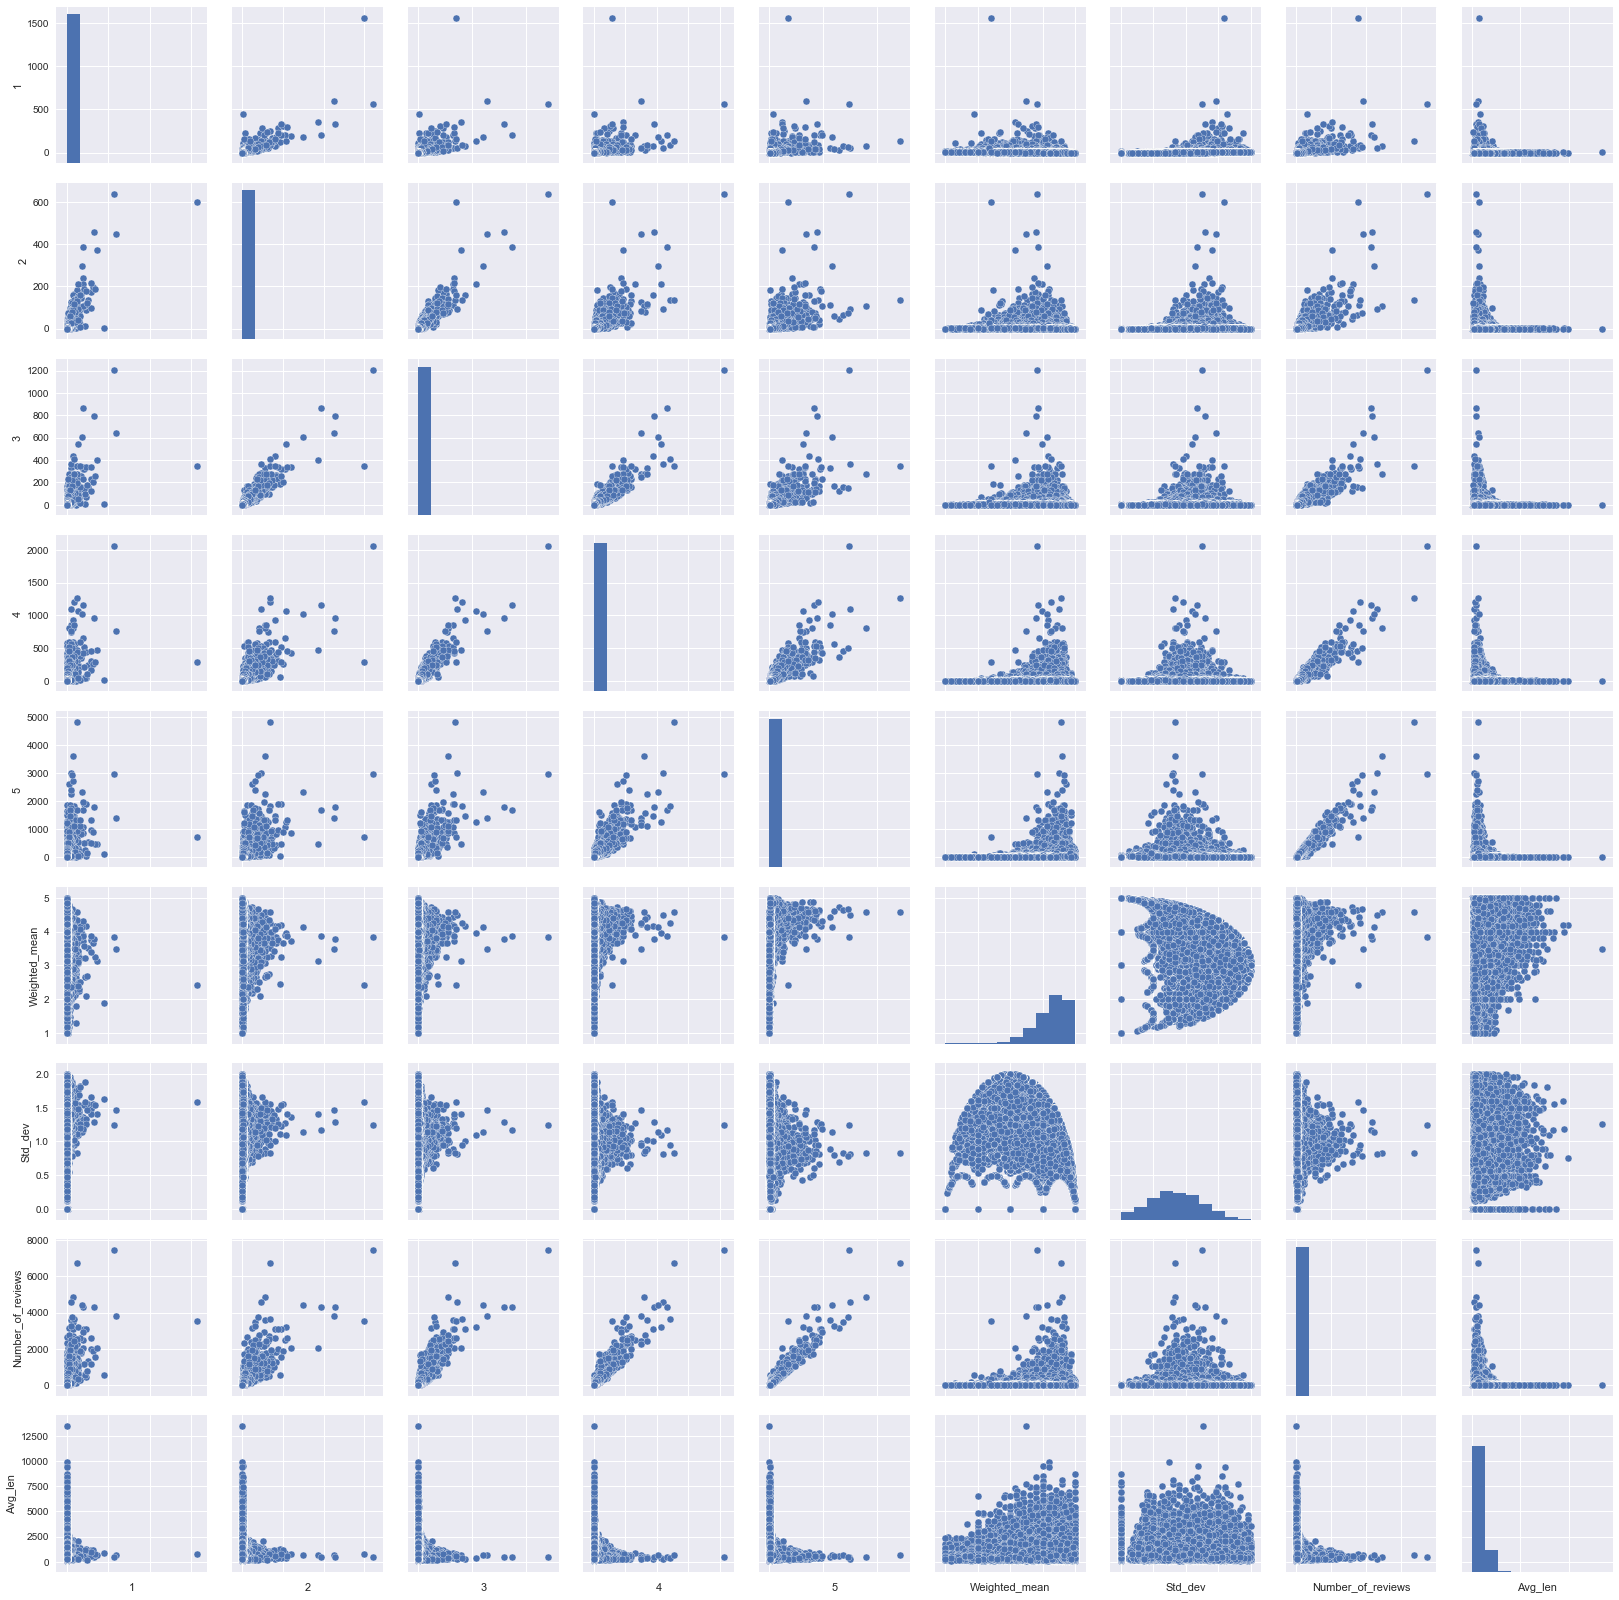

In [224]:
g = sns.pairplot(ratings_grouped_unstack_df)
g.set(xticklabels=[])

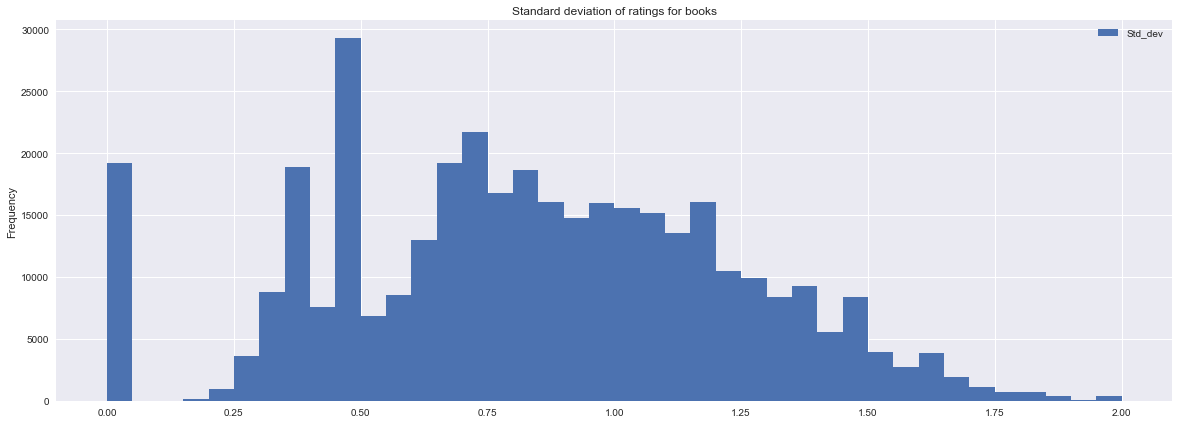

In [26]:
ratings_grouped_unstack_df.plot(y = 'Std_dev', kind = 'hist', bins = 40, figsize = (20,7), 
        title = 'Standard deviation of ratings for books')

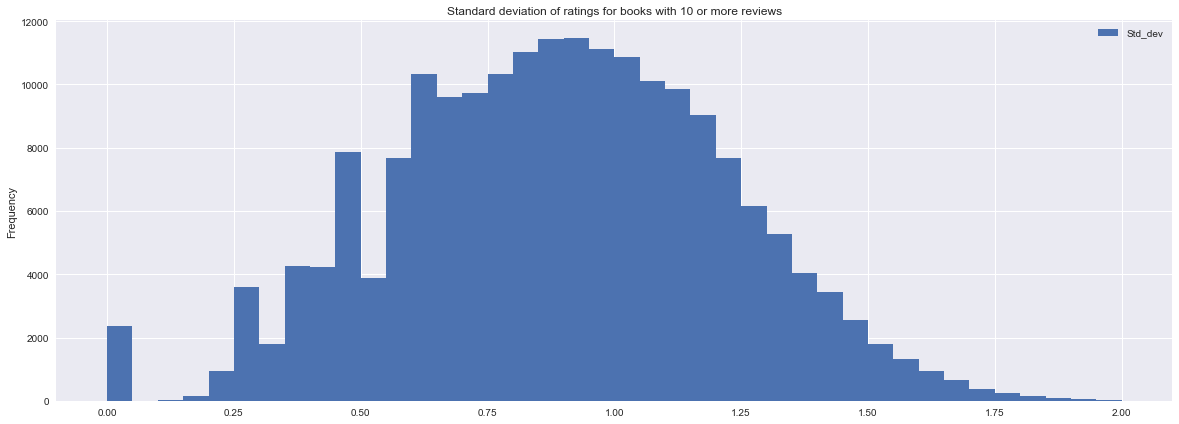

In [27]:
ratings_grouped_unstack_df[ratings_grouped_unstack_df['Number_of_reviews'] > 9].plot(y = 'Std_dev', 
        kind = 'hist', bins = 40, figsize = (20,7), 
        title = 'Standard deviation of ratings for books with 10 or more reviews')

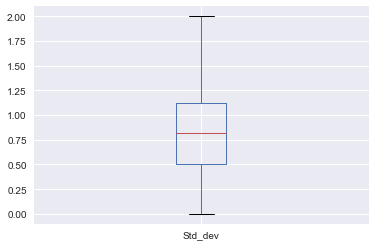

In [80]:
ratings_grouped_unstack_df.plot(y = 'Std_dev', kind = 'box')

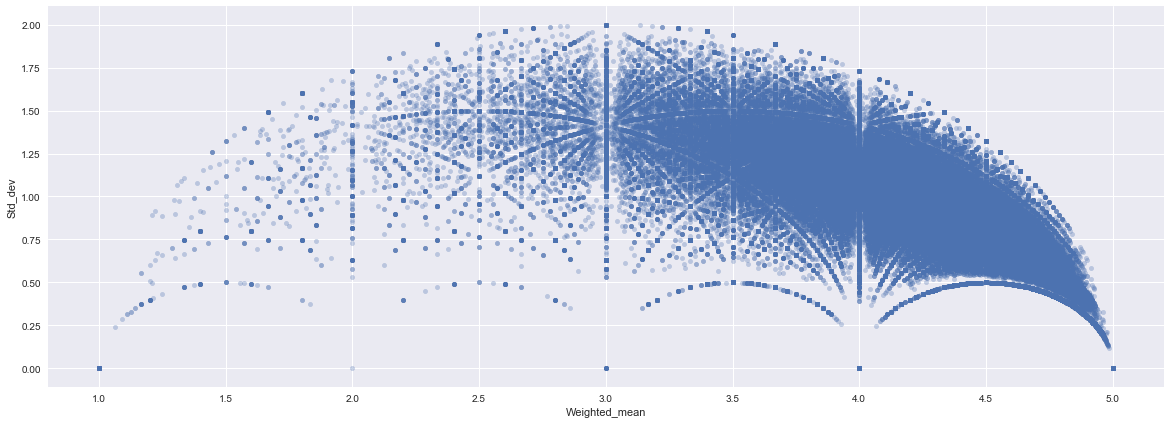

In [28]:
ratings_grouped_unstack_df.plot(x = 'Weighted_mean', y = 'Std_dev', kind = 'scatter', alpha = 0.3, figsize = (20,7))

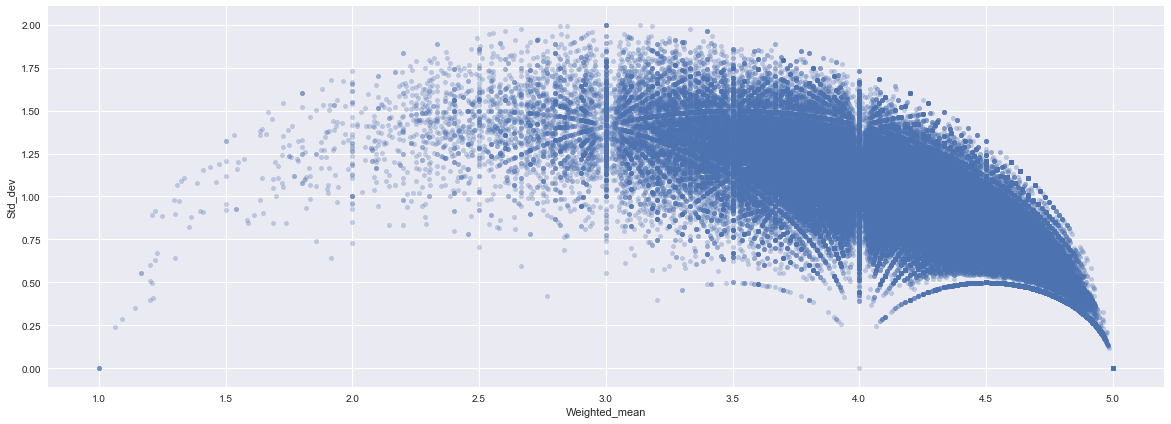

In [29]:
ratings_grouped_unstack_df[ratings_grouped_unstack_df['Number_of_reviews'] > 9].plot(x = 'Weighted_mean', y = 'Std_dev', kind = 'scatter', alpha = 0.3, figsize = (20,7))

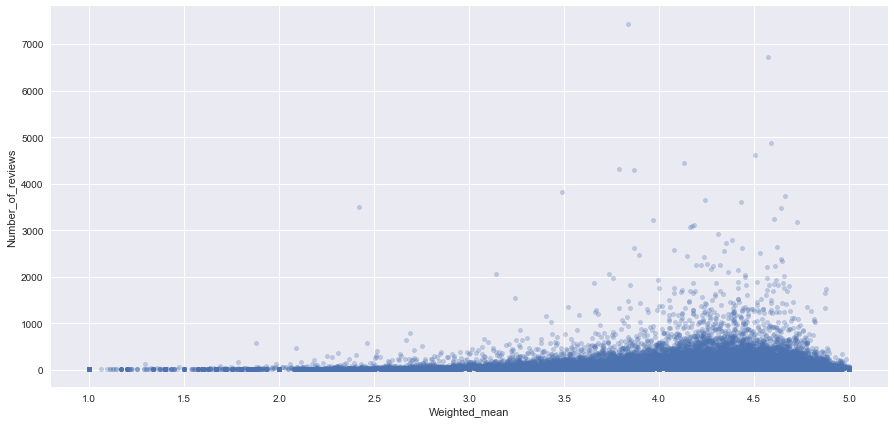

In [30]:
ratings_grouped_unstack_df.plot(x = 'Weighted_mean', y = 'Number_of_reviews', kind = 'scatter', alpha = 0.3, figsize = (15,7))

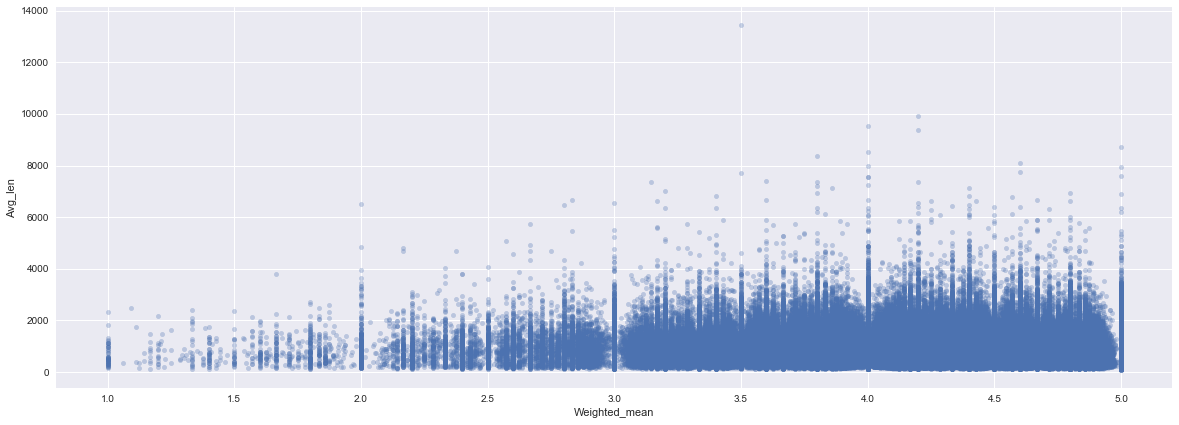

In [31]:
ratings_grouped_unstack_df.plot(x = 'Weighted_mean', y = 'Avg_len', kind = 'scatter', figsize = (20,7), alpha = 0.3)

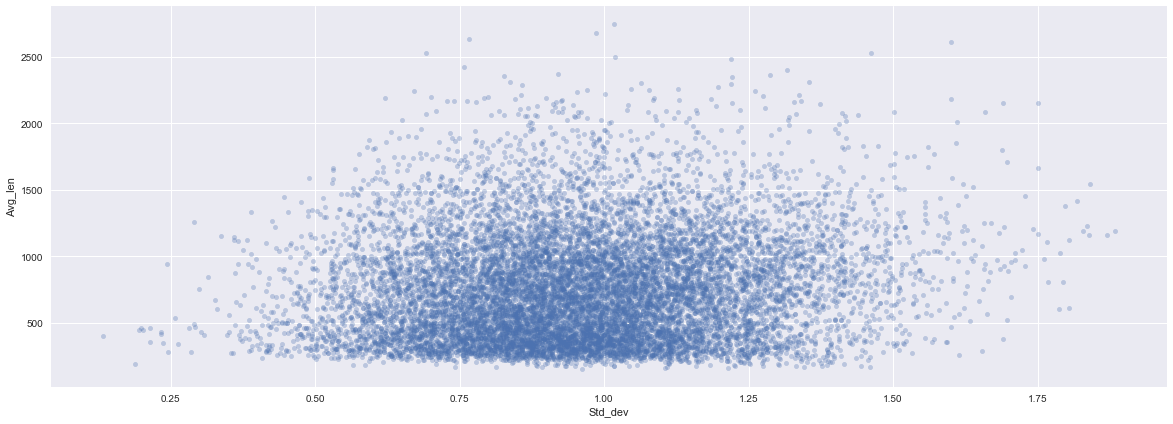

In [32]:
ratings_grouped_unstack_df[ratings_grouped_unstack_df['Number_of_reviews'] > 100].plot(x = 'Std_dev', y = 'Avg_len', kind = 'scatter', figsize = (20,7), alpha = 0.3)

In [36]:
books_low_std = ratings_grouped_unstack_df[ratings_grouped_unstack_df['Std_dev'] < 0.507]
books_high_std = ratings_grouped_unstack_df[ratings_grouped_unstack_df['Std_dev'] > 1.18]
print(books_low_std.shape[0], books_high_std.shape[0])

91945 73906


In [37]:
books_low_std.describe()

,1,2,3,4,5,Weighted_mean,Std_dev,Number_of_reviews,Avg_len
count,91945.000000,91945.000000,91945.000000,91945.000000,91945.000000,91945.000000,91945.000000,91945.000000,91945.000000
mean,0.007320,0.005351,0.075186,2.132003,7.780184,4.743573,0.332847,10.000044,850.340227
std,0.221183,0.119972,0.441639,2.430834,13.635870,0.276237,0.181190,15.338557,570.802787
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,63.000000
25%,0.000000,0.000000,0.000000,1.000000,4.000000,4.625000,0.300000,5.000000,430.387097
50%,0.000000,0.000000,0.000000,2.000000,5.000000,4.800000,0.400000,7.000000,710.833333
75%,0.000000,0.000000,0.000000,3.000000,8.000000,4.900000,0.471405,10.000000,1117.833333
max,20.000000,12.000000,27.000000,125.000000,1604.000000,5.000000,0.506812,1731.000000,8716.000000


In [38]:
books_high_std.describe()

,1,2,3,4,5,Weighted_mean,Std_dev,Number_of_reviews,Avg_len
count,73906.000000,73906.000000,73906.000000,73906.000000,73906.000000,73906.000000,73906.000000,73906.000000,73906.000000
mean,2.817782,2.212107,3.098273,4.711634,9.610140,3.697671,1.390584,22.449936,901.369553
std,9.829752,7.157018,10.577516,15.644846,31.245404,0.472719,0.160412,69.236831,586.023271
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.444444,1.180041,5.000000,103.000000
25%,1.000000,0.000000,0.000000,1.000000,3.000000,3.428571,1.259964,7.000000,477.461538
50%,1.000000,1.000000,1.000000,2.000000,5.000000,3.777778,1.356466,10.000000,781.400000
75%,3.000000,2.000000,3.000000,4.000000,8.000000,4.000000,1.490712,19.000000,1174.356061
max,1565.000000,640.000000,1209.000000,2065.000000,2959.000000,4.600000,2.000000,7440.000000,13459.500000


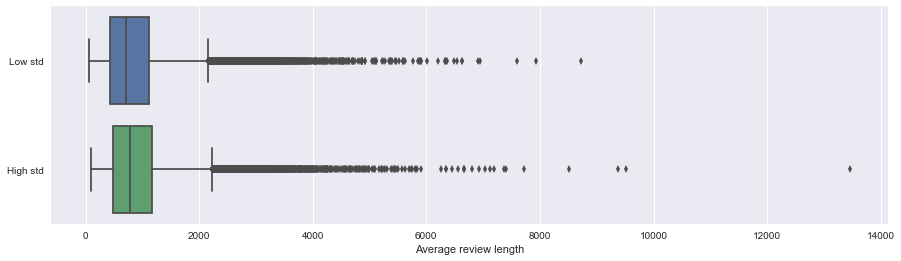

In [39]:
fig, ax1 = plt.subplots(figsize=(15, 4))
bp = sns.boxplot(data = [books_low_std['Avg_len'].values, books_high_std['Avg_len'].values], orient = 'h')
ax1.set_yticklabels(['Low std','High std'])
ax1.set_xlabel("Average review length")

In [40]:
stats.ks_2samp(books_low_std['Avg_len'].values, books_high_std['Avg_len'].values)

Ks_2sampResult(statistic=0.057000797657238644, pvalue=3.4237576578318584e-116)

We can reject hypothesis that these two samples come from the same distribution, so we proved that books with high std dev have on average longer reviews that those with low std_dev. 

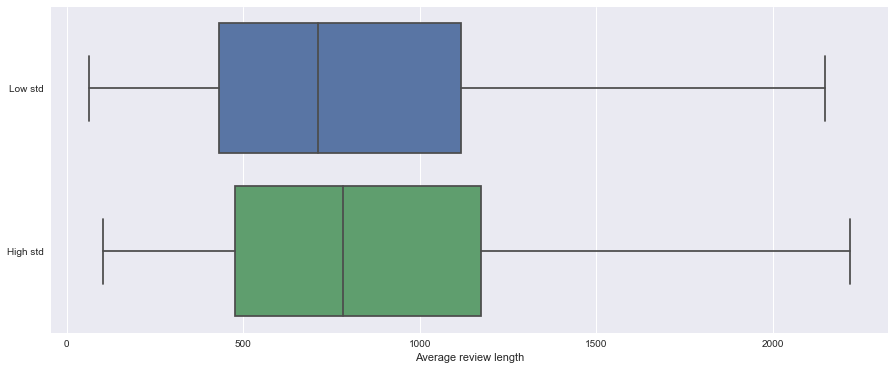

In [45]:
fig, ax1 = plt.subplots(figsize=(15, 6))
bp = sns.boxplot(data = [books_low_std['Avg_len'].values, books_high_std['Avg_len'].values], orient = 'h', showfliers=False)
ax1.set_yticklabels(['Low std','High std'])
ax1.set_xlabel("Average review length")

In [42]:
def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(data.shape[1])+offset 
    bp = ax.boxplot(data, positions = pos, widths=0.3, patch_artist=True, manage_xticks=False)
#    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
#        plt.setp(bp[element], color=edge_color)
#    for patch in bp['boxes']:
#        patch.set(facecolor=fill_color)

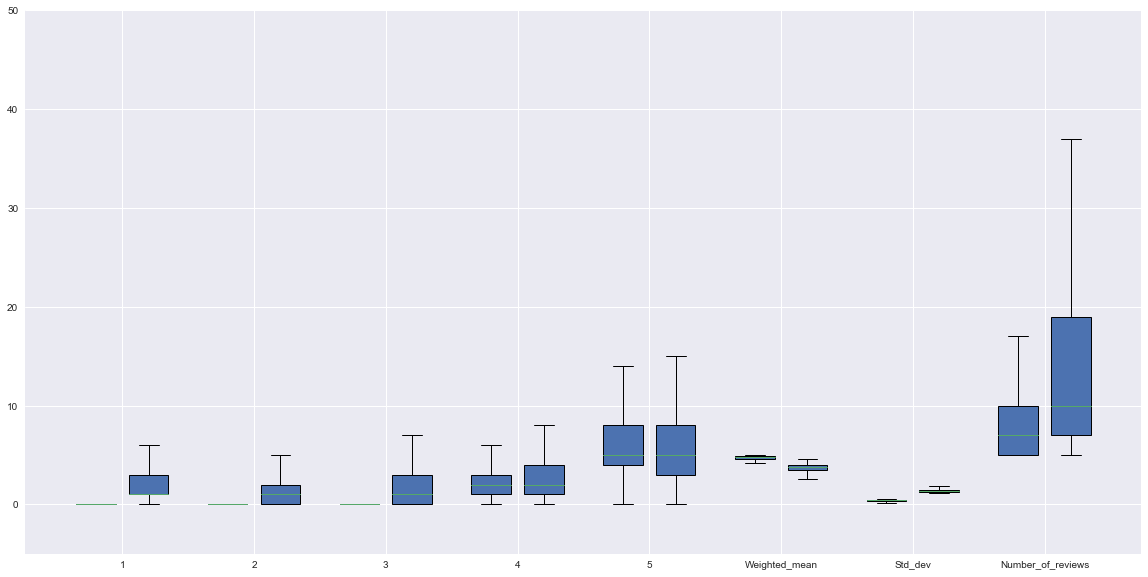

In [44]:
fig, ax = plt.subplots(figsize = (20, 10))
draw_plot(books_low_std.ix[:, books_low_std.columns != "Avg_len"].values, -0.2, "tomato", "white")
draw_plot(books_high_std.ix[:, books_high_std.columns != "Avg_len"].values, +0.2,"skyblue", "white")
ax.set_xticks(np.arange(books_low_std.shape[1] - 1))
ax.set_xticklabels(books_low_std.columns)
ax.set_ylim([-5, 50])
#plt.savefig(__file__+'.png', bbox_inches='tight')
plt.show()
plt.close()

## Collect reviews rating information
Book serial number, date of a review, rating, length of review.

In [14]:
ratings_with_length = df.select("asin", "unixReviewTime", "reviewerID", 'reviewText', 'overall', 'helpful').rdd.map(lambda row: (row.asin, row.unixReviewTime, row.reviewerID, len(row.reviewText), row.overall, row.helpful)).collect()

In [18]:
ratings_with_length_df = pd.DataFrame(ratings_with_length, columns = ["asin", "unixReviewTime", "reviewerID", 'review_length', 'overall', 'helpful'])
ratings_with_length_df['unixReviewTime'] = pd.to_datetime(ratings_with_length_df['unixReviewTime'])
ratings_with_length_df['overall']  = pd.to_numeric(ratings_with_length_df['overall'], downcast='unsigned')
ratings_with_length_df['review_length']  = pd.to_numeric(ratings_with_length_df['review_length'])
ratings_with_length_df.dtypes

In [ ]:
ratings_with_length_df['helpful_yes'] = ratings_with_length_df['helpful'].apply(lambda x: x[0])
ratings_with_length_df['helpful_yes']  = pd.to_numeric(ratings_with_length_df['helpful_yes'])
ratings_with_length_df['helpful_no'] = ratings_with_length_df['helpful'].apply(lambda x: x[1])
ratings_with_length_df['helpful_no']  = pd.to_numeric(ratings_with_length_df['helpful_no'])
ratings_with_length_df.drop('helpful', inplace = True, axis = 1)

In [40]:
ratings_with_length_df.to_csv("ratings_with_length.csv", index=False)

In [35]:
ratings_with_length_df.describe()

,review_length,overall,helpful_yes,helpful_no
count,8.898041e+06,8.898041e+06,8.898041e+06,8.898041e+06
mean,8.189253e+02,4.249932e+00,3.007799e+00,4.050255e+00
std,1.035836e+03,1.057733e+00,1.967758e+01,2.263825e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.920000e+02,4.000000e+00,0.000000e+00,0.000000e+00
50%,4.290000e+02,5.000000e+00,0.000000e+00,1.000000e+00
75%,1.051000e+03,5.000000e+00,2.000000e+00,3.000000e+00
max,3.265800e+04,5.000000e+00,2.331100e+04,2.421200e+04


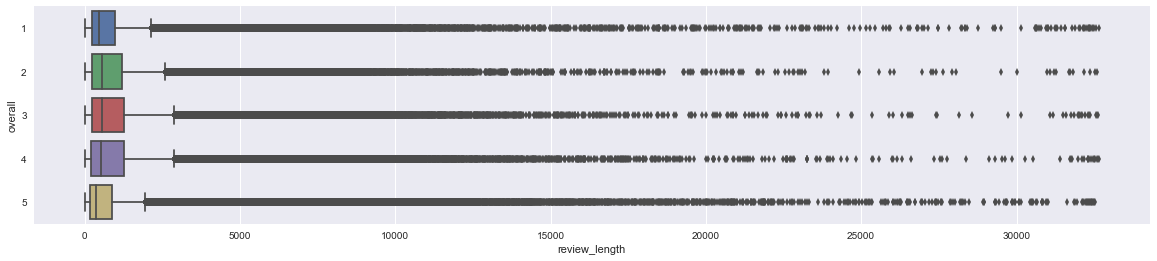

In [49]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
sns.boxplot(y = 'overall', x = 'review_length', data = ratings_with_length_df, orient='h',ax = ax)

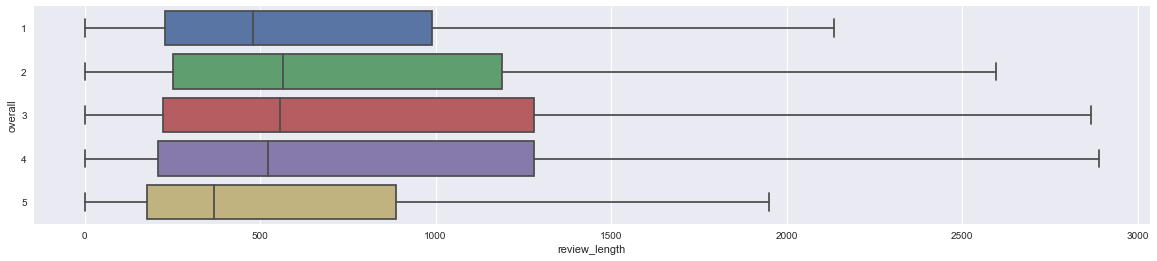

In [50]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
sns.boxplot(y = 'overall', x = 'review_length', data = ratings_with_length_df, orient='h', ax = ax, showfliers=False)

# Categories
## Reviews covered by books with categories

In [129]:
sum(books_with_categories['Number_of_reviews'].values)

2229264

In [126]:
books_with_categories = pd.read_json("product_categories_enhanced.json", lines = True)
books_with_categories = books_with_categories.set_index('asin', drop = True)
books_with_categories.head()

,author,brand,categories,keywords,publisher,release_date,title
asin,,,,,,,
030758836X,Gillian Flynn,Crown,"[[Books, Mystery, Thriller & Suspense, Thrille...","[mystery fiction, wives, 030758836x, thrillers...",Crown,2012-06-05,Gone Girl
0439023483,Suzanne Collins,Scholastic Press,"[[Books, Children's Books, Science Fiction & F...","[science fiction, scholastic press, survival, ...",Scholastic Press,2008-09-14,"The Hunger Games (The Hunger Games, Book 1)"
0375831002,Markus Zusak,Alfred A. Knopf,"[[Books, Children's Books, Literature & Fictio...","[holocaust, the book thief, historical, orphan...",Knopf Books for Young Readers,2006-03-14,The Book Thief
038536315X,John Grisham,John Grisham,"[[Books, Mystery, Thriller & Suspense, Thrille...","[john grisham, political, suspense fiction, ra...",Random House Large Print,2013-10-22,Sycamore Row
0439023513,Suzanne Collins,Scholastic Press,"[[Books, Teens, Literature & Fiction, Social &...","[science fiction, scholastic press, survival, ...",Scholastic Press,2010-08-24,Mockingjay (The Hunger Games)


In [128]:
books_with_categories = pd.merge(books_with_categories, ratings_grouped_unstack_df, left_index=True, right_index=True, how='inner')

In [158]:
# Unzipping list of lists of categories, extracting all categories to which book is assigned
all_categories = books_with_categories['categories'].apply(lambda x: 
        list(set([item for lists in x for item in lists])))
all_categories_frequency = dict(Counter(all_categories.sum()))
len(all_categories_frequency)

In [173]:
# Most popular categories
sorted_all_categories_frequency = sorted(all_categories_frequency.items(), key=operator.itemgetter(1), reverse=True)
sorted_all_categories_frequency[:100]

## K-Means to cluster datapoints

For n_clusters = 2 The average silhouette_score is : 0.605456255789
4401
10599


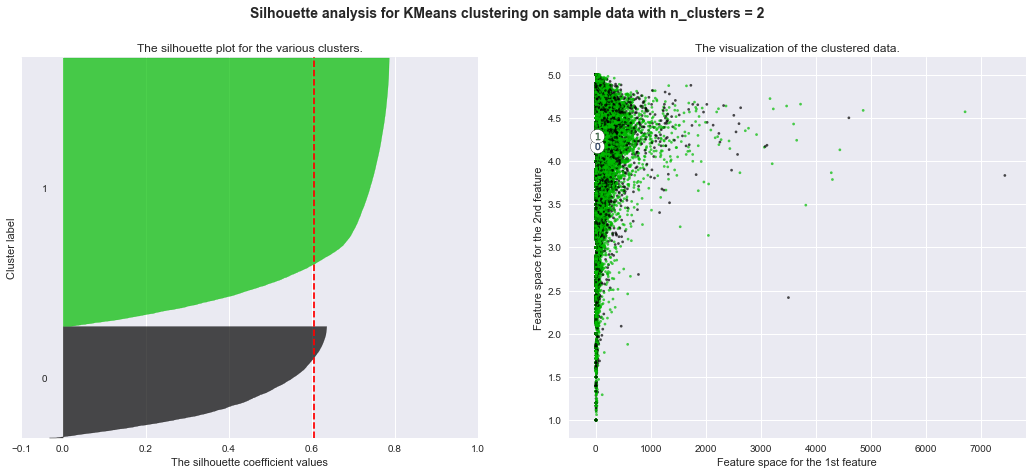

For n_clusters = 3 The average silhouette_score is : 0.565506575443
7945
1564
5491


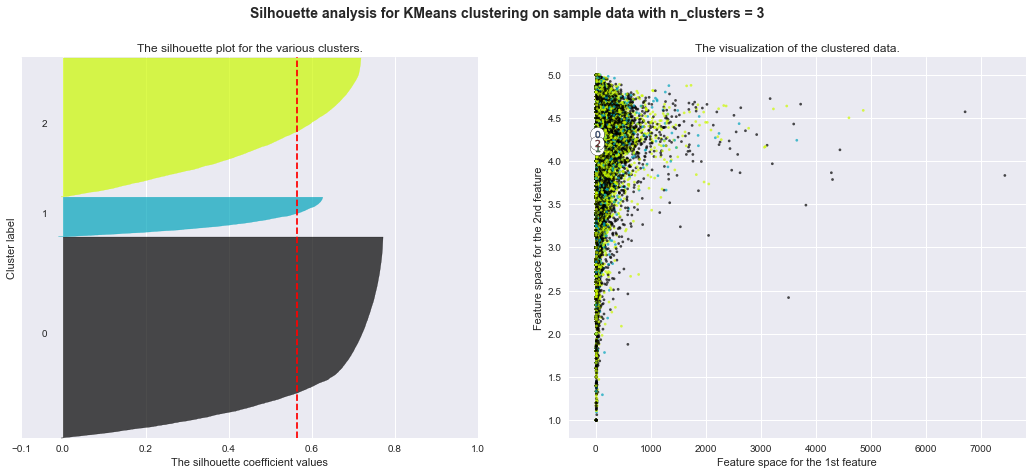

For n_clusters = 4 The average silhouette_score is : 0.549236961701
4995
2748
6565
692


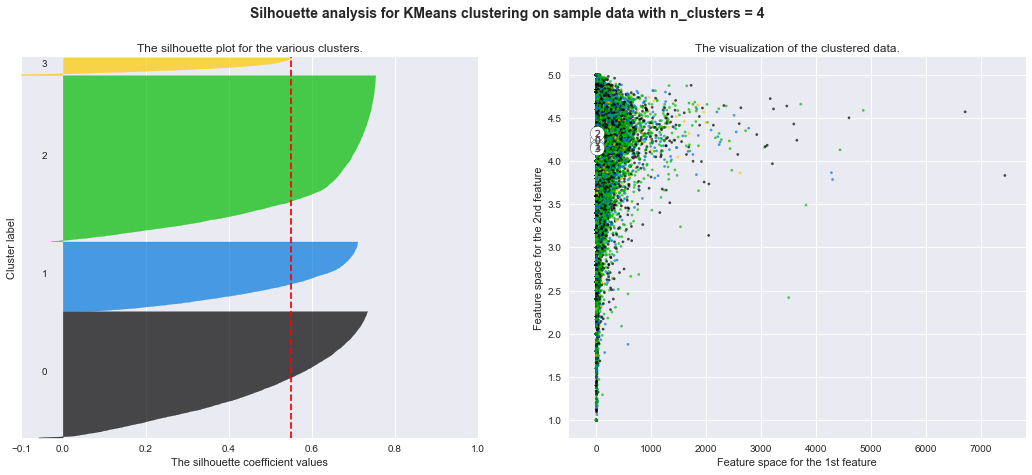

For n_clusters = 5 The average silhouette_score is : 0.52430263359
4181
486
3407
2143
4783


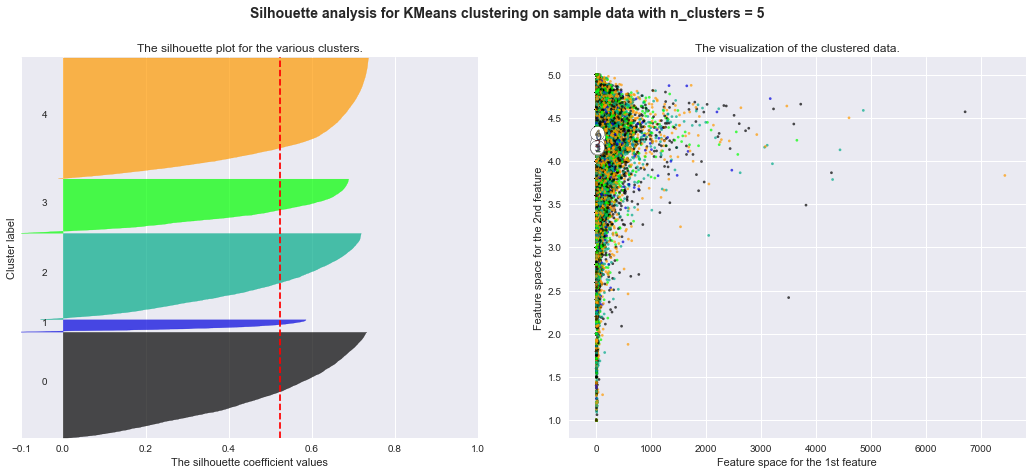

For n_clusters = 6 The average silhouette_score is : 0.51741134872
3297
2066
4316
1005
4031
285


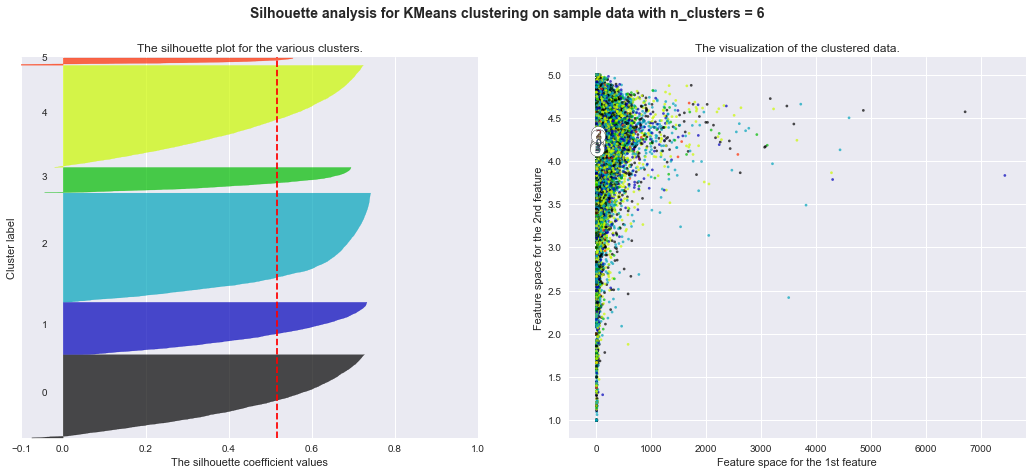

For n_clusters = 7 The average silhouette_score is : 0.497772266529
2599
1821
3254
925
3102
277
3022


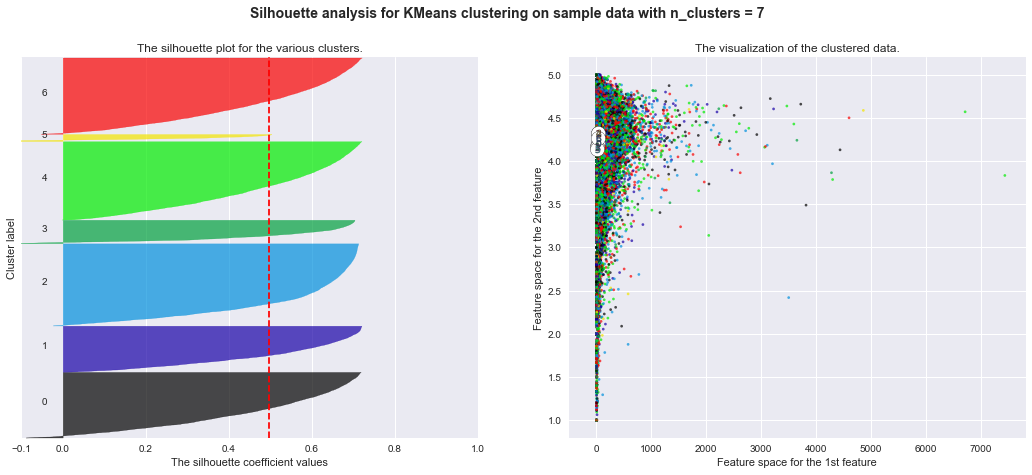

For n_clusters = 8 The average silhouette_score is : 0.504782891189
54
1674
3276
949
3099
288
3007
2653


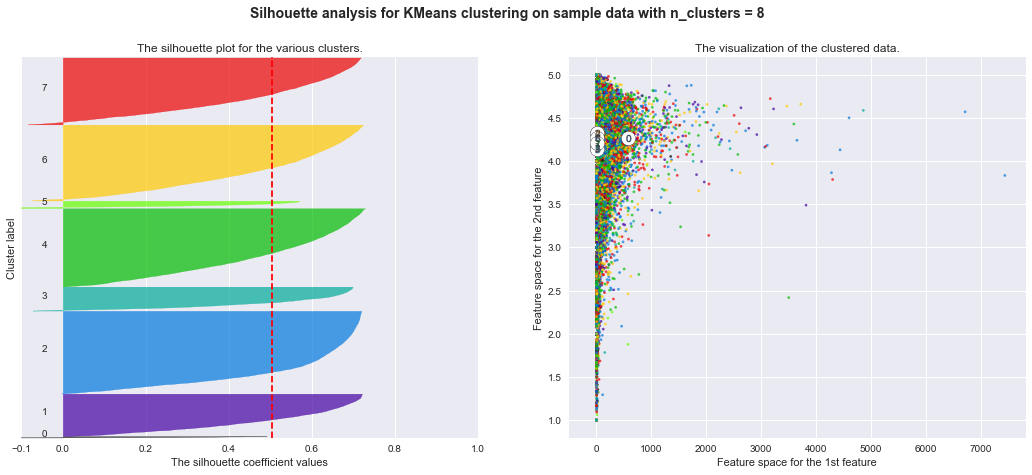

For n_clusters = 9 The average silhouette_score is : 0.47794246451
79
1746
2350
904
2503
242
2749
2628
1799


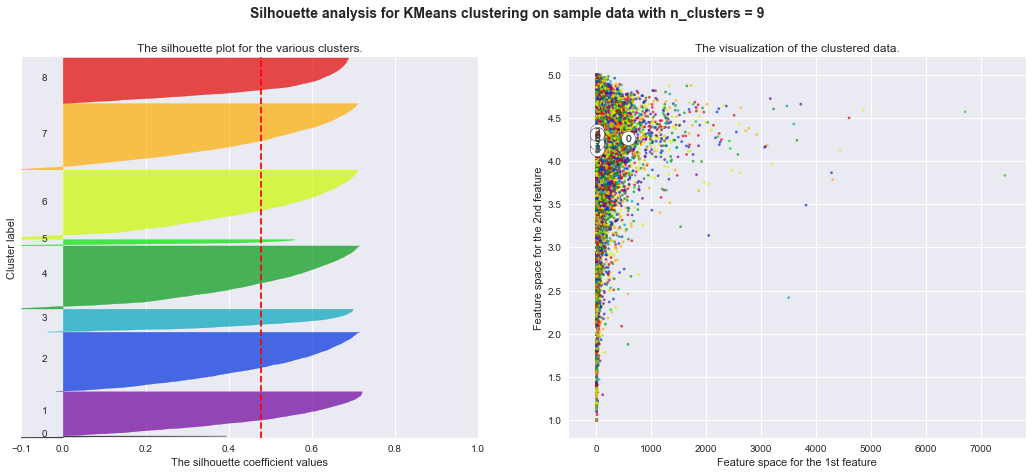

For n_clusters = 10 The average silhouette_score is : 0.43890444645
2025
255
2113
1572
1345
1479
1535
2076
1790
810


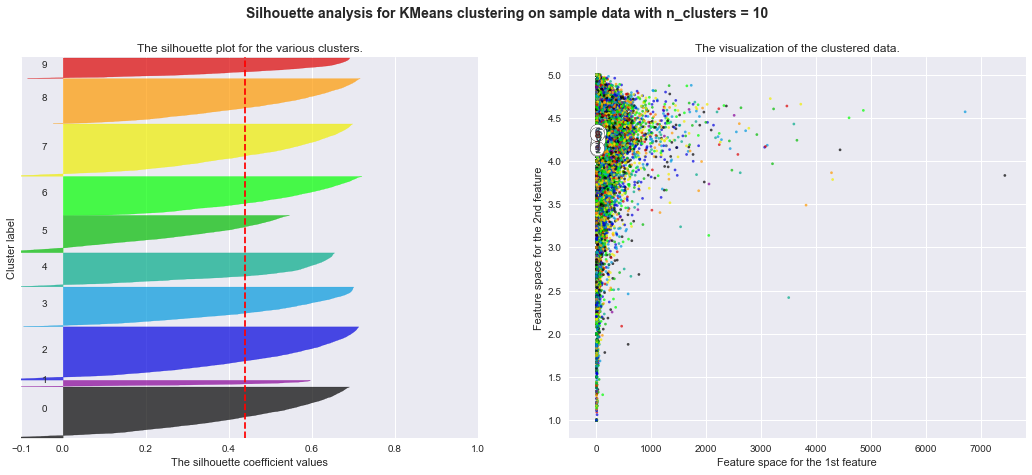

In [106]:
X = ratings_grouped_unstack_df[['Number_of_reviews', 'Weighted_mean', 'Std_dev', 'Avg_len']].values
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, 15000 + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.  
    clusterer = MiniBatchKMeans(init='random', n_clusters=n_clusters, batch_size=40000,
                      n_init=10, max_no_improvement=10, verbose=0, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    X_sample, cluster_labels_sample = resample(X, cluster_labels, replace = False, n_samples = 15000)
    sample_silhouette_values = silhouette_samples(X_sample, cluster_labels_sample)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels_sample == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        print(size_cluster_i)
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels_sample.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

# Data analysis

By the previous look at the data, we drew the conclusion that we would focus on the negative and positive ratings. We will therefore, for now, focus on the file giving the number of 1,2,3,4 and 5 stars ratings for each book. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#create a dataframe with the ratings for each books and the length and total number or reviews
reviews_df_raw=pd.DataFrame.from_csv('ratings_grouped_unstack.csv')
d1=pd.DataFrame.from_csv('avg_length_and_number_of_reviews_per_book.csv')

In [4]:
reviews_df_raw.head()

,1,2,3,4,5
asin,,,,,
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5


In this dataset, asin is the Amazon identifier for the book, and the column named 1 (respectively 2, 3, 4 and 5) corresponds to how many reviews were associated with a rating of 1 star (respectively 2, 3, 4 and 5 stars) (every time someone reviews a book they need to rate the book from 1 star to 5). 


We can start by plotting the total number of ratings for each number of stars.

([<matplotlib.axis.XTick at 0x264122a1668>,
 <a list of 5 Text xticklabel objects>)

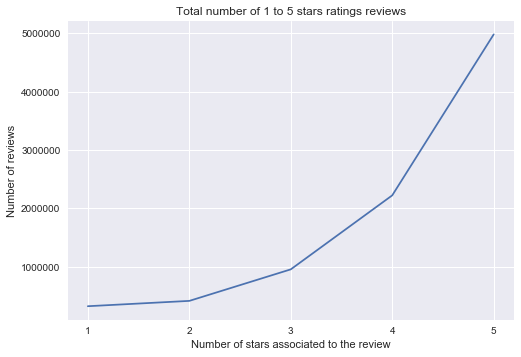

In [5]:
x = reviews_df_raw.columns
y = reviews_df_raw.sum()

plt.plot(x,y)
plt.title('Total number of 1 to 5 stars ratings reviews')
plt.ylabel('Number of reviews')
plt.xlabel('Number of stars associated to the review')
plt.xticks([1,2,3,4,5])

Let's try to plot the logarithm of y for this plot to see if we can find something interesting.

([<matplotlib.axis.XTick at 0x2641233c860>,
 <a list of 5 Text xticklabel objects>)

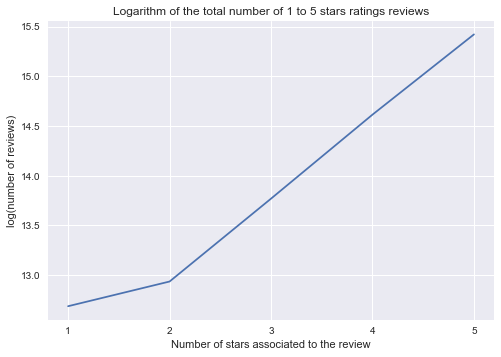

In [6]:
y2=np.log(y)
g=plt.plot(x,y2)

plt.title('Logarithm of the total number of 1 to 5 stars ratings reviews')
plt.ylabel('log(number of reviews)')
plt.xlabel('Number of stars associated to the review')
plt.xticks([1,2,3,4,5])

From 2 to 5 stars the logarithm of y gives a straight line! This means that people would give exponentially more 5 stars than 2 stars rating. This is a very interesting discovery that will be needed to be questionned further, by, for example, checking if in the Amazon rules concerning reviews something could explain this. 


#### We will now try to find "good books" , "controversial books" and "bad books" defined as follow:
* "good book"= many high ratings hew low ratings 
* "bad book" = many low ratings few high ratings  
* "controversial book" = any kind of ratings with small variance between number of reviews with 1,2,3,4 or 5 stars 


In [13]:
# merge the two datasets and calculate the "bad ratio" and "good_ratio" for each book
#bad_ratio and good_ratio are defined as the number of 1,2 stars (resp 4,5 stars) divided 
#by the total number of reviews 

d1['asin']=d1.index
reviews_df_raw['asin']=reviews_df_raw.index
reviews_df_tot=pd.merge(reviews_df_raw, d1, on=['asin'])
reviews_df_tot['bad_ratio']= (reviews_df_tot['1']+reviews_df_tot['2'])/(reviews_df_tot['1']+reviews_df_tot['2']+reviews_df_tot['3']+reviews_df_tot['4']+reviews_df_tot['5'])
reviews_df_tot['good_ratio']= (reviews_df_tot['4']+reviews_df_tot['5'])/(reviews_df_tot['1']+reviews_df_tot['2']+reviews_df_tot['3']+reviews_df_tot['4']+reviews_df_tot['5'])


reviews_df_tot.head()

,1,2,3,4,5,asin,Avg_len,number_of_reviews,bad_ratio,good_ratio
0,6,4,8,15,173,000100039X,638.033981,206,0.048544,0.912621
1,0,4,2,10,2,0001055178,1308.611111,18,0.222222,0.666667
2,1,0,0,2,13,0001473123,287.937500,16,0.062500,0.937500
3,0,0,0,0,7,0001473727,187.571429,7,0.000000,1.000000
4,0,0,1,0,5,0001473905,481.833333,6,0.000000,0.833333


For our analysis to make sense, we need to take books that have a significative number of reviews as if the book only has one or two reviews that is negative/positive, the book will be directly classified as a bad/good book and this is not reliable. However, if we take a minimum too high for the number of reviews of a book, we will have very few "bad books" as, we will see that the bulk of bad books have very few comments. 

We will try with a limit of 10 reviews. 

In [14]:
reviews_df = reviews_df_tot.copy()[reviews_df_tot.number_of_reviews>10]

In [15]:
# as a first guess, we can define bad books as having a bad ratio higher than 0.7 
#(respectively lower than 0.7 for good books)


#we will compare how many bad books we have if we consider the all dataset and if we consider only the books that have more than 10 reviews (for reliability)
bad_books_tot = reviews_df_tot[reviews_df_tot.bad_ratio>0.7]
bad_books = reviews_df[reviews_df.bad_ratio>0.7]

#As we have already a significant number of good and controversial books with our limit, we just consider with the limit 
good_books = reviews_df[reviews_df.good_ratio>0.7]
controversial_books= reviews_df[abs(reviews_df.good_ratio-reviews_df.bad_ratio)<0.1]



In [16]:
bad_books_tot.describe()

,1,2,3,4,5,Avg_len,number_of_reviews,bad_ratio,good_ratio
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,5.973291,1.967949,0.591880,0.475427,0.849359,852.246335,9.857906,0.816833,0.123201
std,16.132484,2.010411,1.105213,0.930433,4.037758,577.108054,21.163739,0.085686,0.095057
min,0.000000,0.000000,0.000000,0.000000,0.000000,116.666667,5.000000,0.704545,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,449.900000,5.000000,0.750000,0.000000
50%,4.000000,2.000000,0.000000,0.000000,0.000000,710.778333,7.000000,0.800000,0.142857
75%,6.000000,3.000000,1.000000,1.000000,1.000000,1128.700000,9.000000,0.843117,0.200000
max,447.000000,20.000000,14.000000,12.000000,119.000000,6498.200000,582.000000,1.000000,0.294118


In [17]:
bad_books.describe()

,1,2,3,4,5,Avg_len,number_of_reviews,bad_ratio,good_ratio
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,15.794595,3.372973,1.502703,1.140541,2.405405,842.318764,24.216216,0.796491,0.134620
std,34.482998,3.216183,1.981228,1.671933,8.847929,440.475755,44.836257,0.077958,0.076236
min,2.000000,0.000000,0.000000,0.000000,0.000000,147.909091,11.000000,0.704545,0.000000
25%,7.000000,1.000000,0.000000,0.000000,0.000000,539.714286,12.000000,0.733333,0.076923
50%,10.000000,3.000000,1.000000,1.000000,1.000000,768.315789,15.000000,0.777070,0.138889
75%,16.000000,5.000000,2.000000,2.000000,2.000000,1090.764706,21.000000,0.833333,0.187500
max,447.000000,20.000000,14.000000,12.000000,119.000000,2494.909091,582.000000,1.000000,0.294118


As we said before, the number of 'bad books' depends a lot on the limit we take for the minimum number of reviews of our dataset. This might be due to the fact that when books have some bad comments, the books popularity drops and people stop reviewing them very fast. 

In [18]:
good_books.describe()

,1,2,3,4,5,Avg_len,number_of_reviews,bad_ratio,good_ratio
count,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000,142711.000000
mean,0.954432,1.410024,3.788601,10.963324,26.448417,847.175892,43.564799,0.049209,0.870685
std,3.312660,3.970387,9.158551,22.480132,59.200941,491.345135,92.935312,0.053780,0.084861
min,0.000000,0.000000,0.000000,0.000000,0.000000,121.909091,11.000000,0.000000,0.700315
25%,0.000000,0.000000,1.000000,3.000000,9.000000,464.714286,14.000000,0.000000,0.806452
50%,0.000000,0.000000,2.000000,6.000000,13.000000,749.948718,22.000000,0.038462,0.875000
75%,1.000000,1.000000,4.000000,11.000000,25.000000,1117.581144,40.000000,0.080000,0.934783
max,229.000000,298.000000,607.000000,1271.000000,4839.000000,5850.666667,6717.000000,0.296296,1.000000


In [19]:
controversial_books.describe()

,1,2,3,4,5,Avg_len,number_of_reviews,bad_ratio,good_ratio
count,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000,2810.000000
mean,6.190747,5.680783,6.414591,5.698221,6.730961,972.133560,30.715302,0.385675,0.402699
std,12.073168,10.577229,11.582232,12.215638,13.130457,554.989698,57.239637,0.066117,0.063787
min,0.000000,0.000000,0.000000,0.000000,0.000000,136.357143,11.000000,0.090909,0.153846
25%,2.000000,2.000000,2.000000,2.000000,3.000000,553.401786,13.000000,0.347826,0.363636
50%,4.000000,4.000000,4.000000,3.000000,4.000000,908.617908,17.000000,0.384615,0.406250
75%,6.000000,6.000000,7.000000,6.000000,7.000000,1270.751786,30.000000,0.428571,0.454545
max,359.000000,373.000000,397.000000,464.000000,457.000000,4822.833333,2050.000000,0.545455,0.548387


We can already notice that there are way less "bad books" according to our definition and it is very dependent of the limit that we impose for the minimum reviews taken into account in our dataset. This needs to be analysed further. 

As there are many outliers in our dataset, we will plot only robust variables. The first function defined below plots boxplots with outliers and the second one without the outliers. 

In [20]:
def plot_categories(column):
    # Create a figure with 2 subplots and set the title
    fig, ax = plt.subplots(figsize=(15,12), ncols=1, nrows=3)
    plt.suptitle("Boxplots of "+ column + " for three categories of books", fontsize=18)


    # Adjust the sub plots parameters
    hspace =  0.5   

    plt.subplots_adjust(
      hspace  =  hspace
    )


    # Set a title to each graph
    ax[0].set_title("Bad books", fontsize=15)
    ax[1].set_title("Good books", fontsize=15)
    ax[2].set_title("Controversial Books", fontsize=15)

    # Plot the data

    sns.boxplot( bad_books[column], ax=ax[0])
    sns.boxplot( good_books[column], ax= ax[1])
    sns.boxplot( controversial_books[column], ax=ax[2])

    plt.show()

In [21]:
def plot_categories_no_outliers(column):
    # Create a figure with 2 subplots and set the title
    fig, ax = plt.subplots(figsize=(15,12), ncols=1, nrows=3)
    plt.suptitle("Boxplots of "+ column + " for three categories of books", fontsize=18)


    # Adjust the sub plots parameters
    hspace =  0.5   

    plt.subplots_adjust(
      hspace  =  hspace
    )


    # Set a title to each graph
    ax[0].set_title("Bad books", fontsize=15)
    ax[1].set_title("Good books", fontsize=15)
    ax[2].set_title("Controversial Books", fontsize=15)

    # Plot the data

    sns.boxplot( bad_books[column], ax=ax[0], showfliers=False)
    sns.boxplot( good_books[column], ax= ax[1], showfliers=False)
    sns.boxplot( controversial_books[column], ax=ax[2], showfliers=False)

    plt.show()

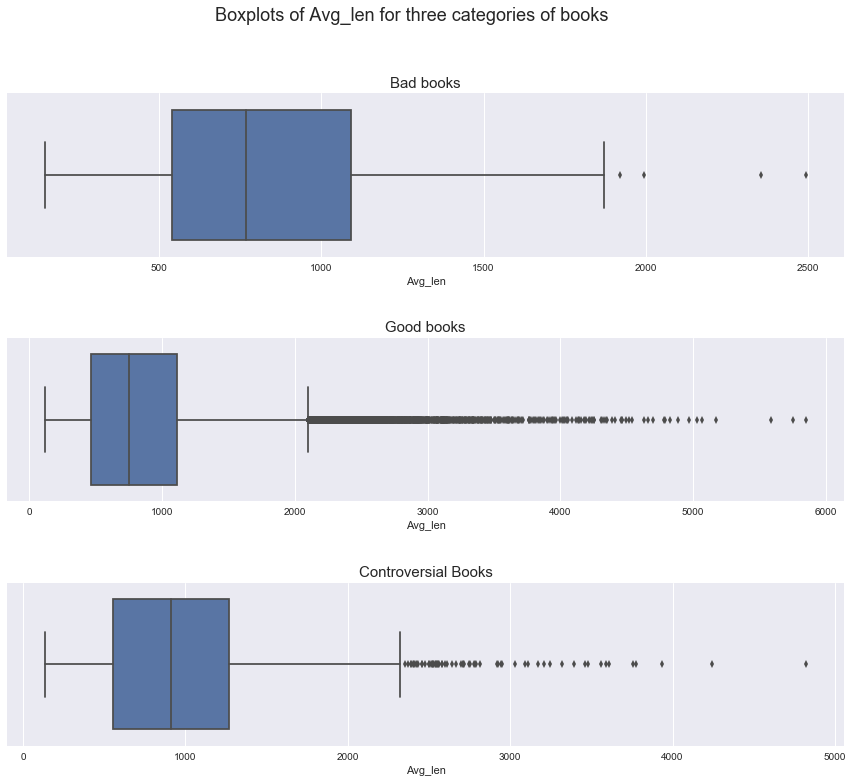

In [22]:
plot_categories('Avg_len')

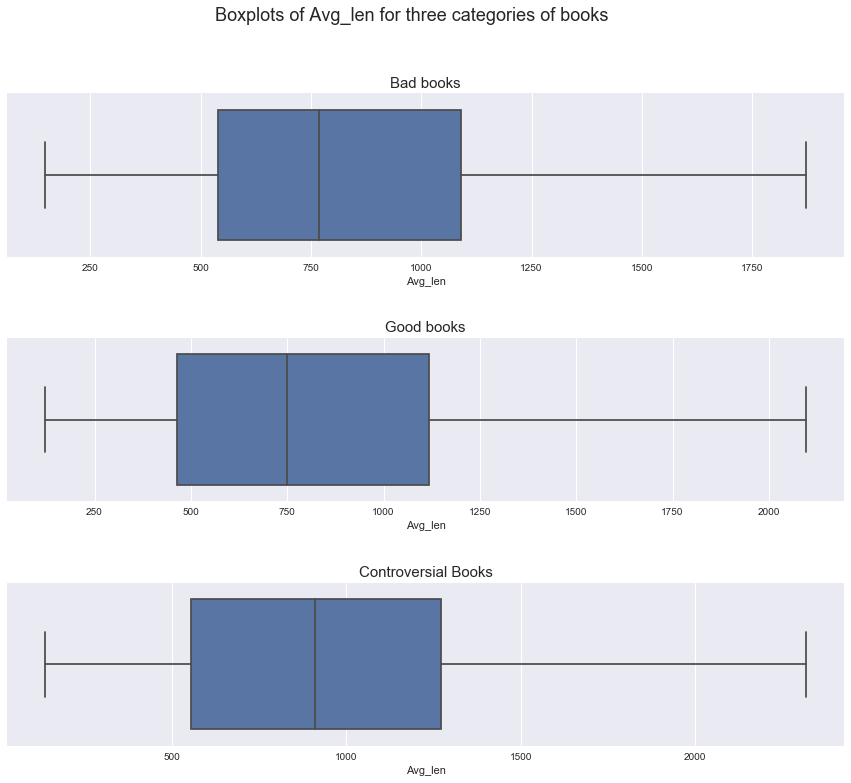

In [23]:
plot_categories_no_outliers('Avg_len')

The average length of the reviews is pretty well balanced through the groups. However, there are way more outliers (longer reviews) in the "good books" and "controversial books" than in the "bad books". The median for controversial books also seems to be a bit higher than for the two other categories. This could be explained by the fact that when people don't agree with each other they are more willing to write longer comments to explain their point of view. However, we see that we need to use more reliable statistics that the bad_ratio and good_ratio that we made up before to be able to draw conclusions. 

#### What we can do now is to try to refine our definitions for the books categories, and to do that we can try to consider mean and standard deviation of the ratings to have maybe more  interpretable results. 

We can calculate the mean and the standard deviation of ratings for each book. We can use these not robust statistics here as the ratings are bound between 1 and 5 so there are no outliers. 

In [34]:
# start again with a copy of our first dataset 
reviews_df_2 = reviews_df_tot.copy()
del reviews_df_2['bad_ratio']
del reviews_df_2['good_ratio']

reviews_df_2.head()

,1,2,3,4,5,asin,Avg_len,number_of_reviews
0,6,4,8,15,173,000100039X,638.033981,206
1,0,4,2,10,2,0001055178,1308.611111,18
2,1,0,0,2,13,0001473123,287.937500,16
3,0,0,0,0,7,0001473727,187.571429,7
4,0,0,1,0,5,0001473905,481.833333,6


In [35]:
# calculate the mean for each book 

reviews_df_2 ['mean_rat'] = (reviews_df_2['1']*1+reviews_df_2['2']*2+reviews_df_2['3']*3+reviews_df_2['4']*4+reviews_df_2['5']*5)/reviews_df_2.number_of_reviews
reviews_df_2.head()


,1,2,3,4,5,asin,Avg_len,number_of_reviews,mean_rat
0,6,4,8,15,173,000100039X,638.033981,206,4.674757
1,0,4,2,10,2,0001055178,1308.611111,18,3.555556
2,1,0,0,2,13,0001473123,287.937500,16,4.625000
3,0,0,0,0,7,0001473727,187.571429,7,5.000000
4,0,0,1,0,5,0001473905,481.833333,6,4.666667


([<matplotlib.axis.XTick at 0x223cea3a978>,
 <a list of 5 Text xticklabel objects>)

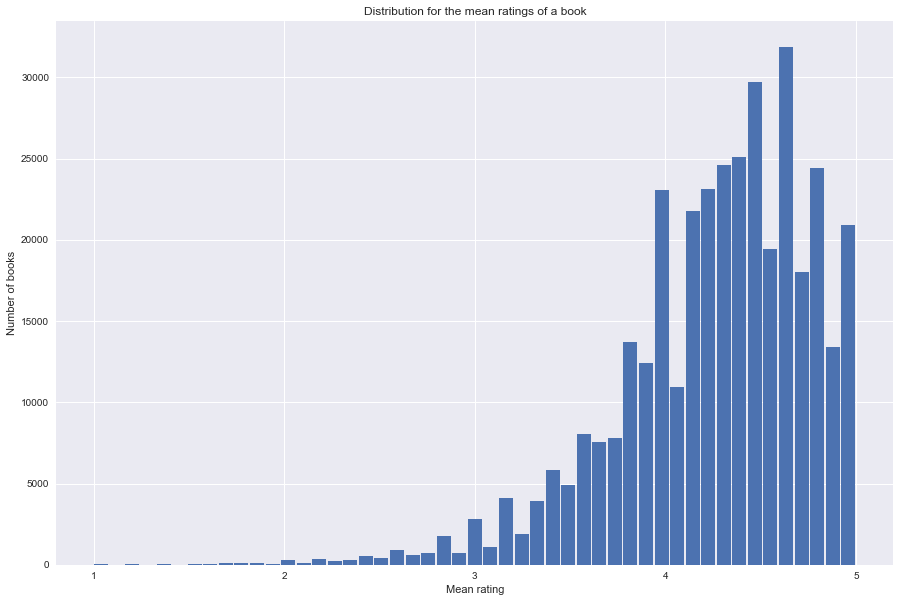

In [36]:
#Plot a histogram 
fig, ax = plt.subplots(figsize=(15,10), ncols=1, nrows=1)

reviews_df_2.mean_rat.hist(bins=np.linspace(1,5,50), rwidth=0.9)




plt.title('Distribution for the mean ratings of a book')
plt.xlabel('Mean rating')
plt.ylabel('Number of books')
plt.xticks([1,2,3,4,5])

We see that the distribution is completely left skewed and we will try to recentre it between 0 and 1 using this article http://rogeriofvieira.com/wp-content/uploads/2016/05/Data-Transformations-1.pdf.

From this article, we see that we can try two transformations: 

 - Logarithms : Growth rates are often exponential and log transforms will
often normalize them. Log transforms are particularly appropriate if the
variance increases with the mean.
 - Reciprocal : If a log transform does not normalize your data you could try a
reciprocal (1/x) transformation. This is often used for enzyme reaction rate
data. 


In [48]:
#Take the transformated weigthed mean as explained in the article 
reviews_df_2['Trans_weighted_mean'] = np.log10(6 - reviews_df_2['mean_rat'].values)

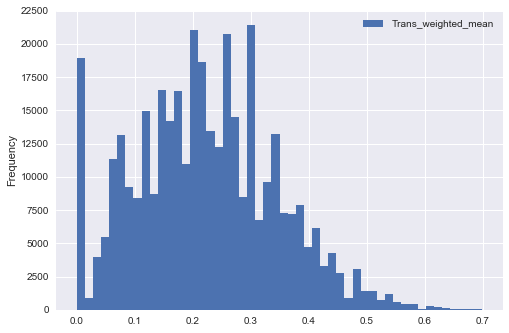

In [38]:
reviews_df_2.plot(y = 'Trans_weighted_mean', kind = 'hist', bins = 50, logx=False)

In [41]:
reviews_df_2['Inverse_weighted_mean'] = 1/(6 - reviews_df_2['mean_rat'].values)

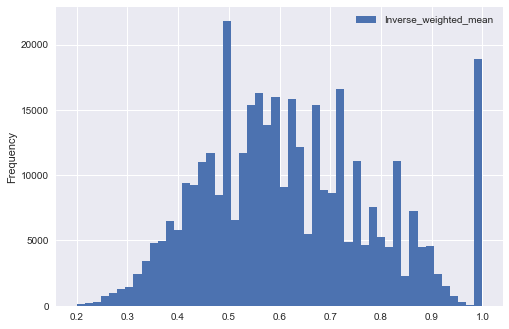

In [42]:
reviews_df_2.plot(y = 'Inverse_weighted_mean', kind = 'hist', bins = 50, logx=False)

We see that this doesn't give very smooth plots and this is due to the books that have just a few ratings and therefore will have values completely equal to 5 for example. As before, we will consider only books that have more than 10 reviews. 

In [43]:
reviews_df_sm = reviews_df_2.copy()[reviews_df_tot.number_of_reviews>10]

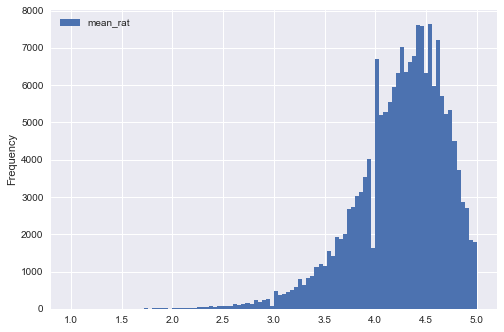

In [45]:
reviews_df_sm.plot(y = 'mean_rat', kind = 'hist', bins = 100, logx=False)

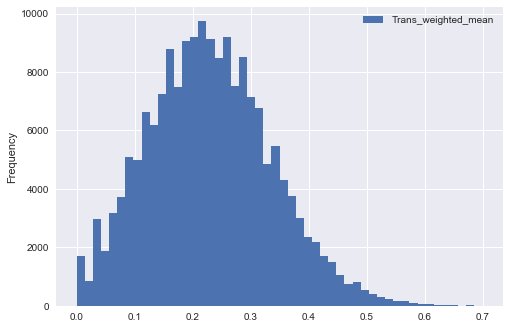

In [46]:
reviews_df_sm.plot(y = 'Trans_weighted_mean', kind = 'hist', bins = 50, logx=False)

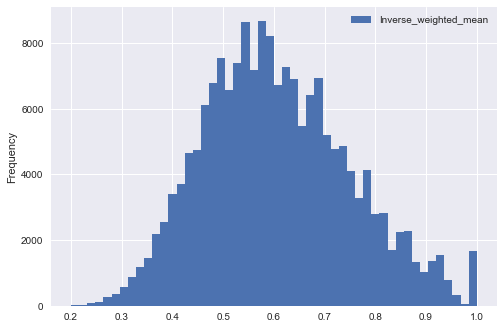

In [47]:
reviews_df_sm.plot(y = 'Inverse_weighted_mean', kind = 'hist', bins = 50, logx=False)

Now the graphs look way better. We can then refine our definitions for "good", "bad" and also add "neutral" books as following:

* "bad" book = the books in the 25% on the left of this plot
* "neutral" book = the books in the 50% in the middle of this plot
* "good" book = the books in the 25% on the right of this plot

We will also analyse the standard deviation to define what is a "controversial" book. 

After those definitions are set, we can try to see if they would match with a sentimental analysis model like Vader: Vader can predict if a sentence is negative or positive and we could see if a review is negative and positive and compare this to the number of stars it is related to.

In [ ]:
# Spark context shutdown
sc.stop()

# Roadmap for the future
Our internal milestones up until the report are:

- Decide all models of grouping data into categories (negative/positive, fast/slow plateauing of review numbers, etc.)

- Decide parameters and thresholds for category definitions based on the data

- Enrich data by scraping Amazon for genres as extensively as possible

- Create necessary intermediate files containing formatted data, to speed up analysis and computing

- Find the best way to use VADER to analyze positivity and negativity of reviews

- Calculate correlations between popularity metrics and positive and negative reviews and ratings
  * With respect to time
  * By aggregation by category (good, bad, controversial)
  * By aggregation by genre and author

- If necessary, run analysis on the cluster

- Find the exact data story we want to tell (choose exact questions), make it compelling, and link it to social good

- Decide format of report

- Depending on report format, distribute tasks to individual group members

- Produce good, polished visualizations that tell the story

- Construct report into a coherent document

- Update readme according to progress

- Create a plan for presentation and poster creation

The enrichment of the data will be done using the **Amazon Scraper.ipynb** notebook, which contains a description of its function (please have a look).

In order to use VADER, we will have to decide how to apply its sentence-based logic to entire reviews. The obvious way is to analyze each sentence and take the mean score, but we will look into whether this is the most sensible way or if another way would be more relevant.

In the future, these and many more notebook cells will be filled:

In [16]:
# Retrieve sentiments of reviews:
# TODO...

In [17]:
# Calculate correlations:
# TODO...

In [18]:
# Produce final visualizations:
# TODO...